# Данные и Функции

### Подключение к Гугл-диску

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/content/

Mounted at /content/drive
/content/drive/MyDrive/content




### Импорт библиотек


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import scipy
import random
import math as m
import re
import heapq
warnings.filterwarnings('ignore')
import seaborn as sns
from tabulate import tabulate

### Вывод и очистка данных с гугл-диска

In [ ]:
df_c = pd.read_csv('Close.csv', index_col=0)
df_hh = pd.read_csv('High.csv', index_col=0)
df_ll = pd.read_csv('Low.csv', index_col=0)
df_oo = pd.read_csv('Open.csv', index_col=0)
df_vv = pd.read_csv('Volume.csv', index_col=0)

In [ ]:
df = df_c[~df_c.index.duplicated(keep='first')].T
df_h = df_hh[~df_hh.index.duplicated(keep='first')].T
df_l = df_ll[~df_ll.index.duplicated(keep='first')].T
df_o = df_oo[~df_oo.index.duplicated(keep='first')].T
df_v = df_vv[~df_vv.index.duplicated(keep='first')].T


In [ ]:
def clean_data(df):
    df = df.mask((abs(10*df/df.shift(-1) - 1) < 0.1) & (abs(10*df/df.shift(1) - 1) < 0.1), 10*df)
    df = df.mask((abs(100*df/df.shift(-1) - 1) < 0.1) & (abs(100*df/df.shift(1) - 1) < 0.1), 100*df)
    # df.columns = range(df.shape[1])
    df.index = pd.to_datetime(df.index)
    return df
df = clean_data(df)
df_h = clean_data(df_h)
df_l = clean_data(df_l)
df_o = clean_data(df_o)
df_v = clean_data(df_v)


## 1. Функция нейтрализации

In [ ]:
def neutralization(alp):
  return (alp.T - alp.mean(axis="columns")).T

## 2. Функция нормализации

In [ ]:
def normalization(alp):
    return (alp.T / alp.abs().sum(axis=1)).T

## 3. Альфа −closei(d − 1)/closei(d − 6)

In [ ]:
alp = -df.shift(1)/ df.shift(6) + 1

## Нейтрализация и нормализация

In [ ]:
alp = normalization(neutralization(alp))

## Проверка альфы на нейтральность и нормальность

In [ ]:
alp.sum(axis=1) #проверка нейтрализации

2010-01-04    0.000000e+00
2010-01-05    0.000000e+00
2010-01-06    0.000000e+00
2010-01-07    0.000000e+00
2010-01-08    0.000000e+00
                  ...     
2014-12-24    1.387779e-17
2014-12-26   -4.163336e-17
2014-12-29    1.387779e-17
2014-12-30   -6.938894e-18
2014-12-31   -1.734723e-17
Length: 1257, dtype: float64

In [ ]:
alp.abs().sum(axis=1) # нормализация проверка

2010-01-04    0.0
2010-01-05    0.0
2010-01-06    0.0
2010-01-07    0.0
2010-01-08    0.0
             ... 
2014-12-24    1.0
2014-12-26    1.0
2014-12-29    1.0
2014-12-30    1.0
2014-12-31    1.0
Length: 1257, dtype: float64

##  4. Матрица доходностей интсрументов

### 4.1 Return(d)

In [ ]:
def return_dd(df):
    return_d = df / df.shift(1) - 1
    return return_d

In [ ]:
return_d = return_dd(df)

### 4.2 Функция доходности

In [ ]:
def pnl(alp):
    pnll = alp.shift(2) * return_dd(df)
    return pnll.sum(axis=1)

## 5. Turnover

In [ ]:
def turnover_d(alp):
    return alp.diff().abs().sum(axis=1)

# для каждого дня

In [ ]:
def turnover(alp):
  turnovers = []
  for i in range(5):
    turnovers.append(alp[252*i:252*(i+1)].diff().abs().sum(axis=1).mean())
  return turnovers

  # средний за год

In [ ]:
turnover(alp)

[0.623796095343561,
 0.6452044800341541,
 0.637135285264622,
 0.6331544209726667,
 0.6303180501525997]

## 6. Sharp

In [ ]:
def sharpe_d(pnl, alp, T):
  return pnl(alp).mean()/ pnl(alp).std() * T**0.5

# для каждого дня

In [ ]:
def sharpe(alp):
  sharpes = []
  for i in range(5):
    sharpes.append(pnl(alp)[252*i:252*(i+1)].mean() / pnl(alp)[252*i:252*(i+1)].std() * 252**0.5)

  return sharpes

In [ ]:
sharpe(alp)

[1.5271880798828397,
 1.599249624731013,
 2.6787707157254093,
 1.4773331078336436,
 0.784726531654505]

## 7. Вектор накопленных доходностей Cumpnl



In [ ]:
def cumpnl(alp):
  return pnl(alp).cumsum()

  #для каждого дня

In [ ]:
cumpnl(alp)

2010-01-04    0.000000
2010-01-05    0.000000
2010-01-06    0.000000
2010-01-07    0.000000
2010-01-08    0.000000
                ...   
2014-12-24    0.443799
2014-12-26    0.444810
2014-12-29    0.445931
2014-12-30    0.447061
2014-12-31    0.451031
Length: 1257, dtype: float64

In [ ]:
def cumpnl_Y(alp):
  cumpnls = []
  for i in range(5):
    cumpnls.append(pnl(alp)[252*i:252*(i+1)].sum())

  return cumpnls
  # суммарная доходность по годам

In [ ]:
cumpnl_Y(alp)

[0.08763993203389017,
 0.1444537906804145,
 0.10951763054276223,
 0.05898218566563404,
 0.05043785571645475]

## График Cumpnl

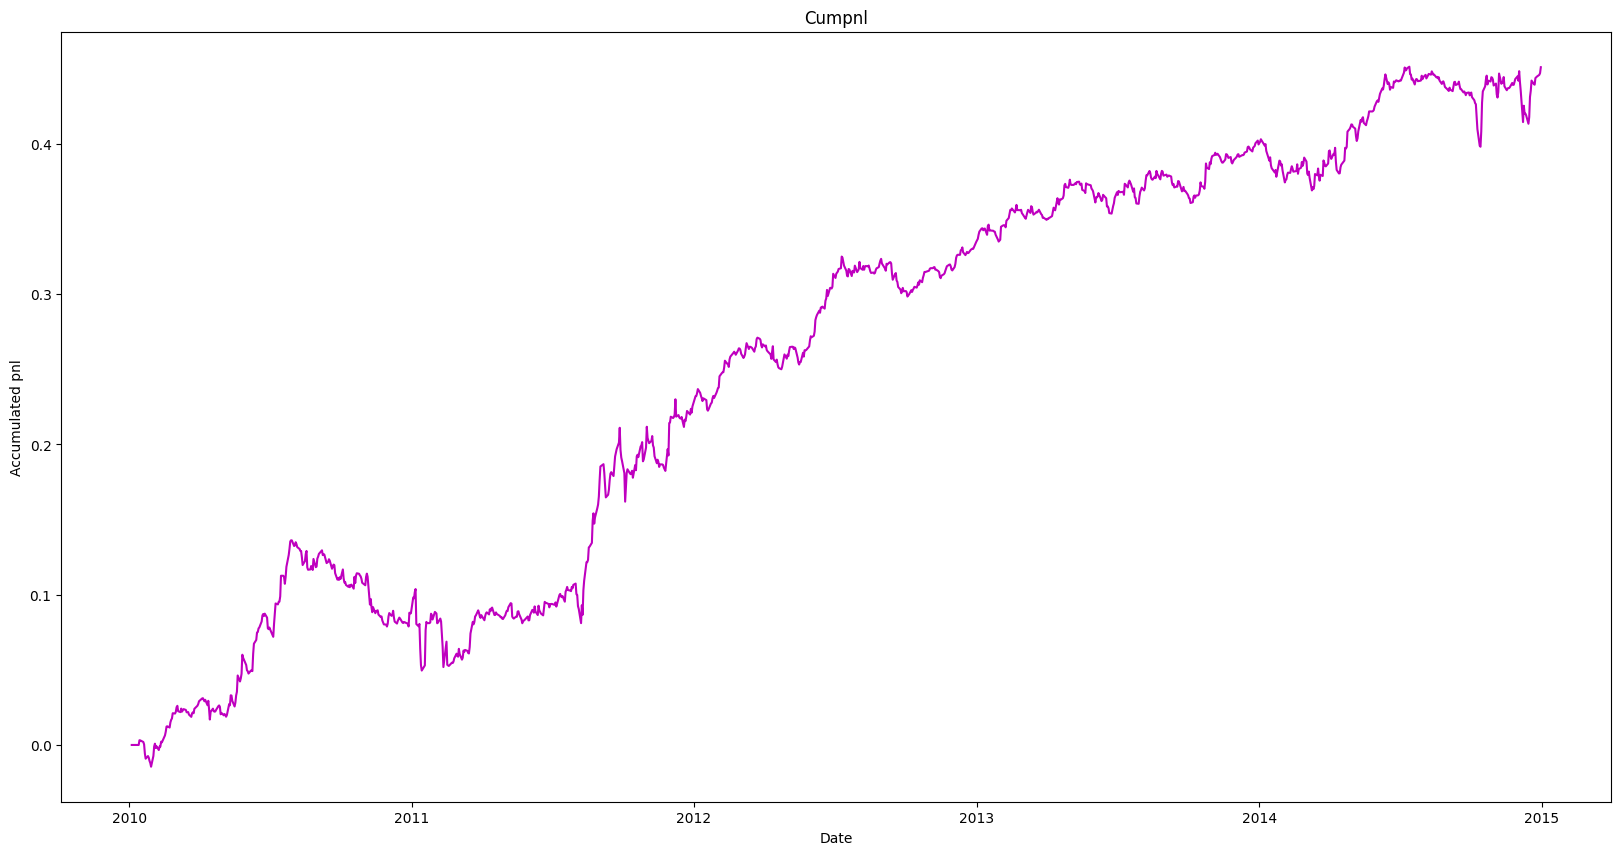

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Cumpnl')
plt.xlabel('Date')
plt.ylabel('Accumulated pnl')
plt.plot((cumpnl(alp)),'m')
plt.rc('font', size= 25 )

plt.show()


## 8. Drawdown

In [ ]:
def drawdown(alp):
    max_drawdown = 0
    max_cumpnl = cumpnl(alp)[0]
    for i in cumpnl(alp):
        if i > max_cumpnl:
            max_cumpnl = i
        else:
            if max_cumpnl - i > max_drawdown:
                max_drawdown = max_cumpnl - i
    return max_drawdown

In [ ]:
drawdown(alp)

0.08666558989292542

## 8. Функция AlphaStats


In [ ]:
def AlphaStats(alp):
    plt.figure(figsize=(20,10))
    plt.title('Return')
    plt.xlabel('Date')
    plt.ylabel('Profit')
    plt.plot(cumpnl(alp), "m")
    plt.legend(['Return'], loc='upper left')
    plt.rc('font', size= 25 )
    plt.show()

# вывод таблицы

    sharpes = []
    turnovers = []
    cumpnls = []
    pnl_sum = []
    drawdownss = []
    years = ["2010", "2011", "2012", "2013", "2014"]
    data = {
            'years': years,
            'sharpes': sharpes,
            'turnovers': turnovers,
            'cumpnls': cumpnls,
            'pnl_sum' : pnl_sum,
            'drawdownss': drawdownss

        }

    data['sharpes'] = sharpe(alp)
    data['turnovers'] = turnover(alp)
    data['cumpnls'] = cumpnl_Y(alp)
    data['pnl_sum'] = pnl(alp).sum()

    for i in range(5):
        data['drawdownss'] = drawdown(alp[252*i:252*(i+1)])


    return pd.DataFrame.from_dict(data)


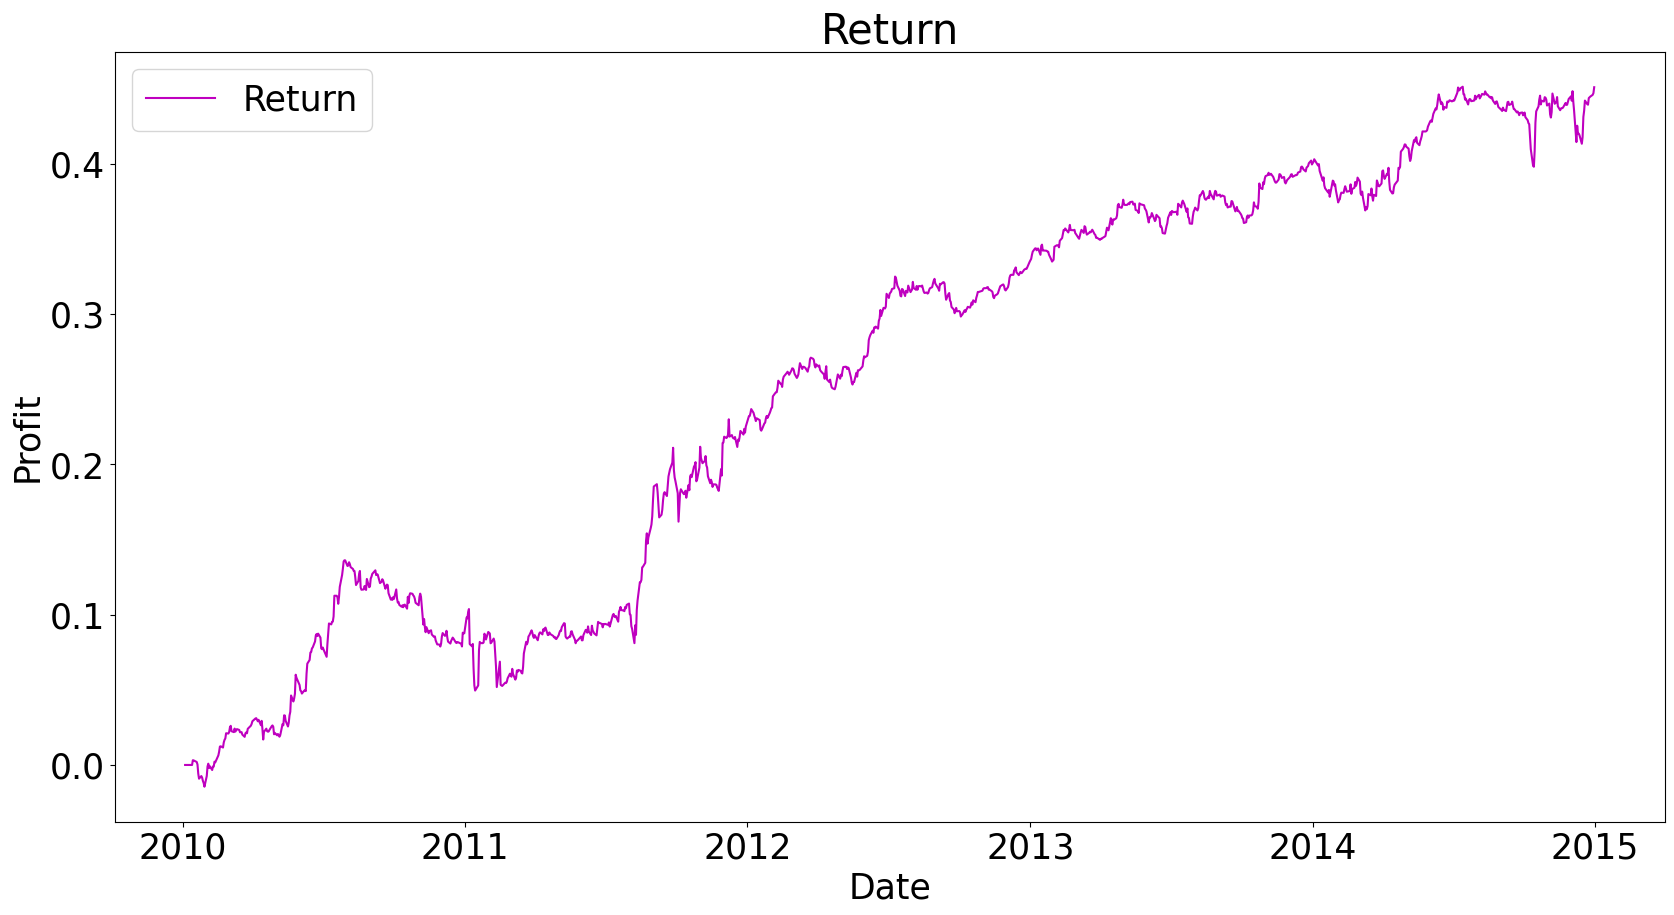

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,1.527188,0.623796,0.087640,0.451031,0.053251
1,2011,1.599250,0.645204,0.144454,0.451031,0.053251
2,2012,2.678771,0.637135,0.109518,0.451031,0.053251
3,2013,1.477333,0.633154,0.058982,0.451031,0.053251
4,2014,0.784727,0.630318,0.050438,0.451031,0.053251


In [ ]:
AlphaStats(alp)

## 10. Truncate

In [ ]:
def truncate(alp, threshold):
  alp = alp.clip(-threshold, threshold)
  alp = normalization(neutralization(alp))
  return alp


In [ ]:
a = truncate(alp, 0.0001)
a.abs().sum(axis=1)

# проверка

2010-01-04    0.0
2010-01-05    0.0
2010-01-06    0.0
2010-01-07    0.0
2010-01-08    0.0
             ... 
2014-12-24    1.0
2014-12-26    1.0
2014-12-29    1.0
2014-12-30    1.0
2014-12-31    1.0
Length: 1257, dtype: float64

## 11. Rank

In [ ]:
def rank(alp):
  alp = (alp.T.rank(axis=0)/(alp.shape[1])).T
  alp = normalization(neutralization(alp))
  return alp

<Axes: >

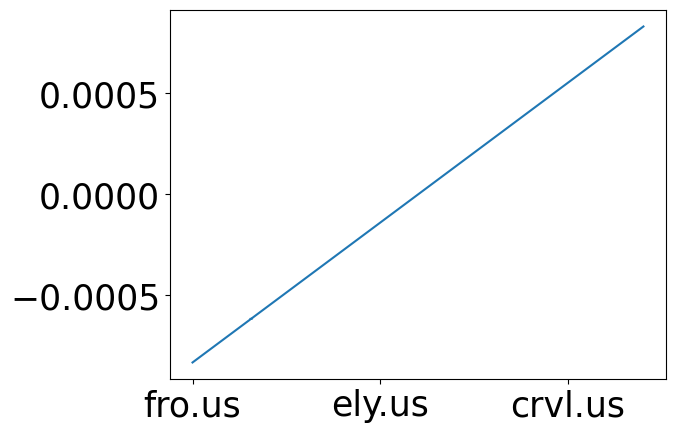

In [ ]:
a=rank(alp)
a.iloc[-10].sort_values().plot()
# проверка

## 12. Волатильность инструментов

In [ ]:
def volatilityy(return_d):
  volatility = return_d.std(axis=0)
  return volatility


In [ ]:
volatilityy(return_d)

iba.us     0.017006
wpz.us     0.015012
flic.us    0.017055
ncs.us     0.029949
gpk.us     0.023794
             ...   
omex.us    0.039132
roic.us    0.010120
nbl.us     0.018658
atu.us     0.019439
apf.us     0.010555
Length: 2404, dtype: float64

График Волатильности

In [ ]:
volatilityy(return_d).sort_values()

spsb.us    0.001190
spab.us    0.002335
spib.us    0.002378
wiw.us     0.004314
egf.us     0.004754
             ...   
srpt.us    0.086048
rvlt.us    0.086528
dest.us    0.120793
fbp.us     0.399168
cpf.us     0.462730
Length: 2404, dtype: float64

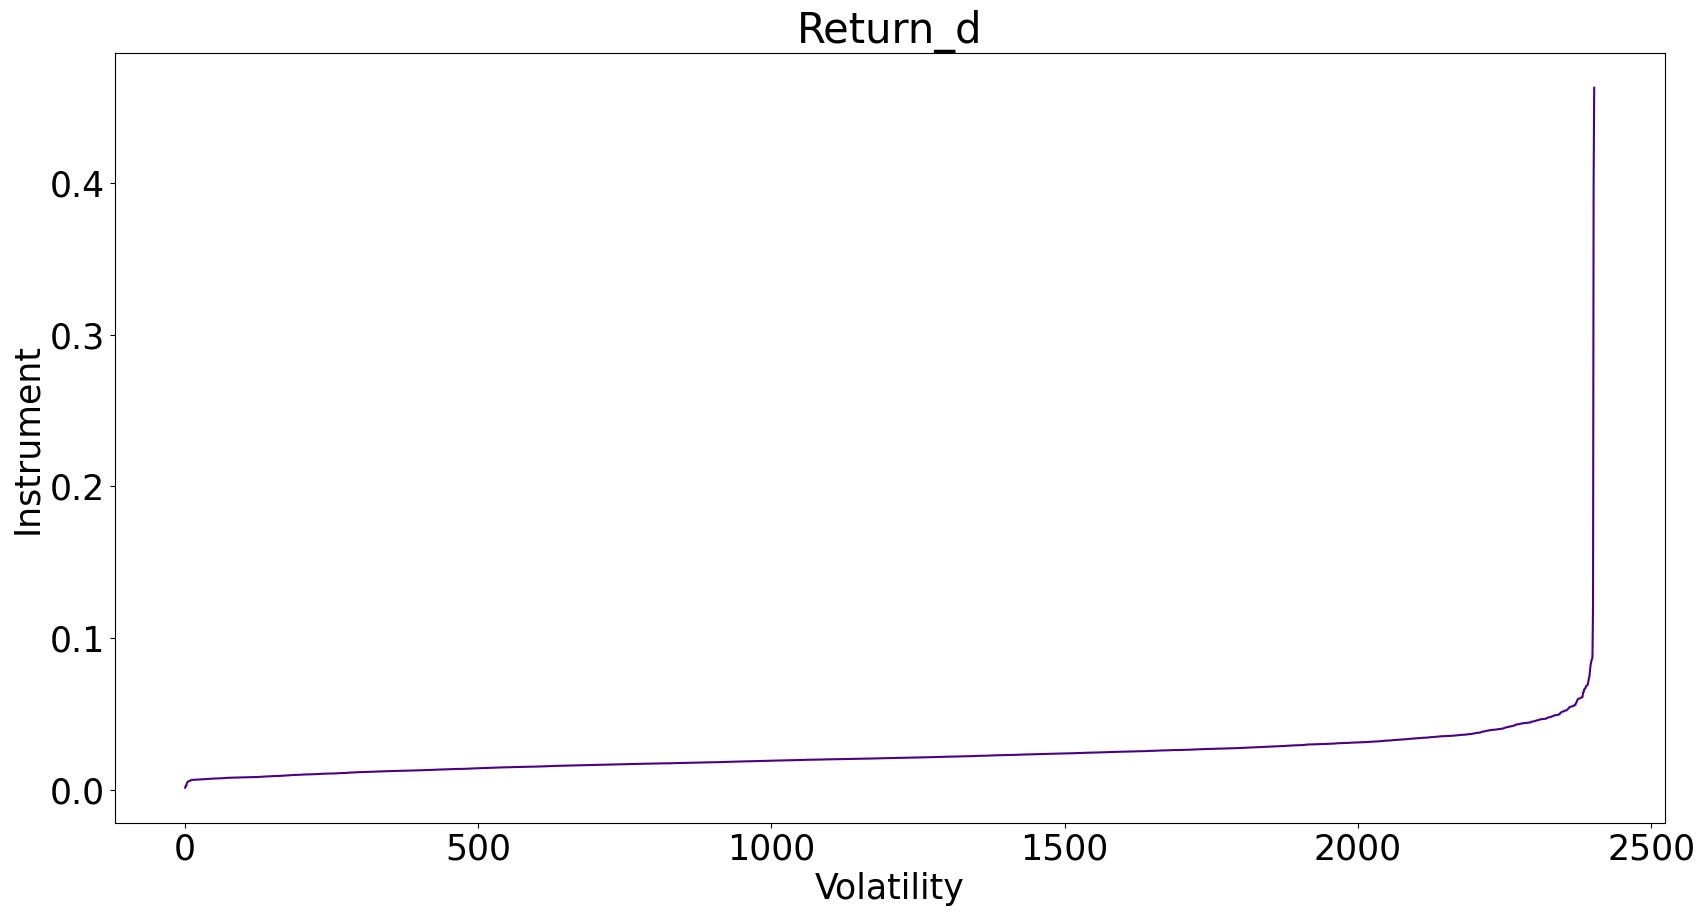

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Return_d')
plt.xlabel('Volatility')
plt.ylabel('Instrument')

plt.plot(volatilityy(return_d).sort_values().reset_index(drop=True), "indigo")
plt.show()

## 13. CutOutliers (Удаление выбросов)

In [ ]:
def CutOutliers(alp, n):

    for date, row in alp.iterrows():
        top_n_indexes = row.nlargest(n).index
        bottom_n_indexes = row.nsmallest(n).index

        alp.loc[date, top_n_indexes] = 0
        alp.loc[date, bottom_n_indexes] = 0

    return alp

## 14. CutMiddle (Удаление средних)

In [ ]:
def CutMiddle_first(alp, n):

    sorted_alp = alp.sort_values()
    low = round((len(alp)/2)-n*0.5)
    high = round((len(alp)/2)+n*0.5)
    middle_indexes = sorted_alp.index[low:high]
    series_without_middle = alp.copy()
    series_without_middle.loc[middle_indexes] = 0
    return series_without_middle

def CutMiddle(dataframe, n):
    return dataframe.T.apply(lambda idx: CutMiddle_first(idx, n)).T


## 15. Decay (функция замедления альф)

In [ ]:
def ts_rank(alp, win):
  alp = alp.rolling(win).rank()
  alp = normalization(neutralization(alp))
  return alp

In [ ]:
def decay(alp, win):
  alp = alp.rolling(win).mean()
  alp = normalization(neutralization(alp))
  return alp

In [ ]:
def decay2(alp, win):
  alp = alp.ewm(win).mean()
  alp = normalization(neutralization(alp))
  return alp

# Построение альф




## Альфа 1

In [ ]:
alp1 = (df - df_l)/(df_h - df_l)*(-1)
alp1 = normalization(neutralization(alp1))
alp1 = ts_rank(alp,5)
alp1 = truncate(alp1, 0.002)
alp1 = decay(alp1,3)

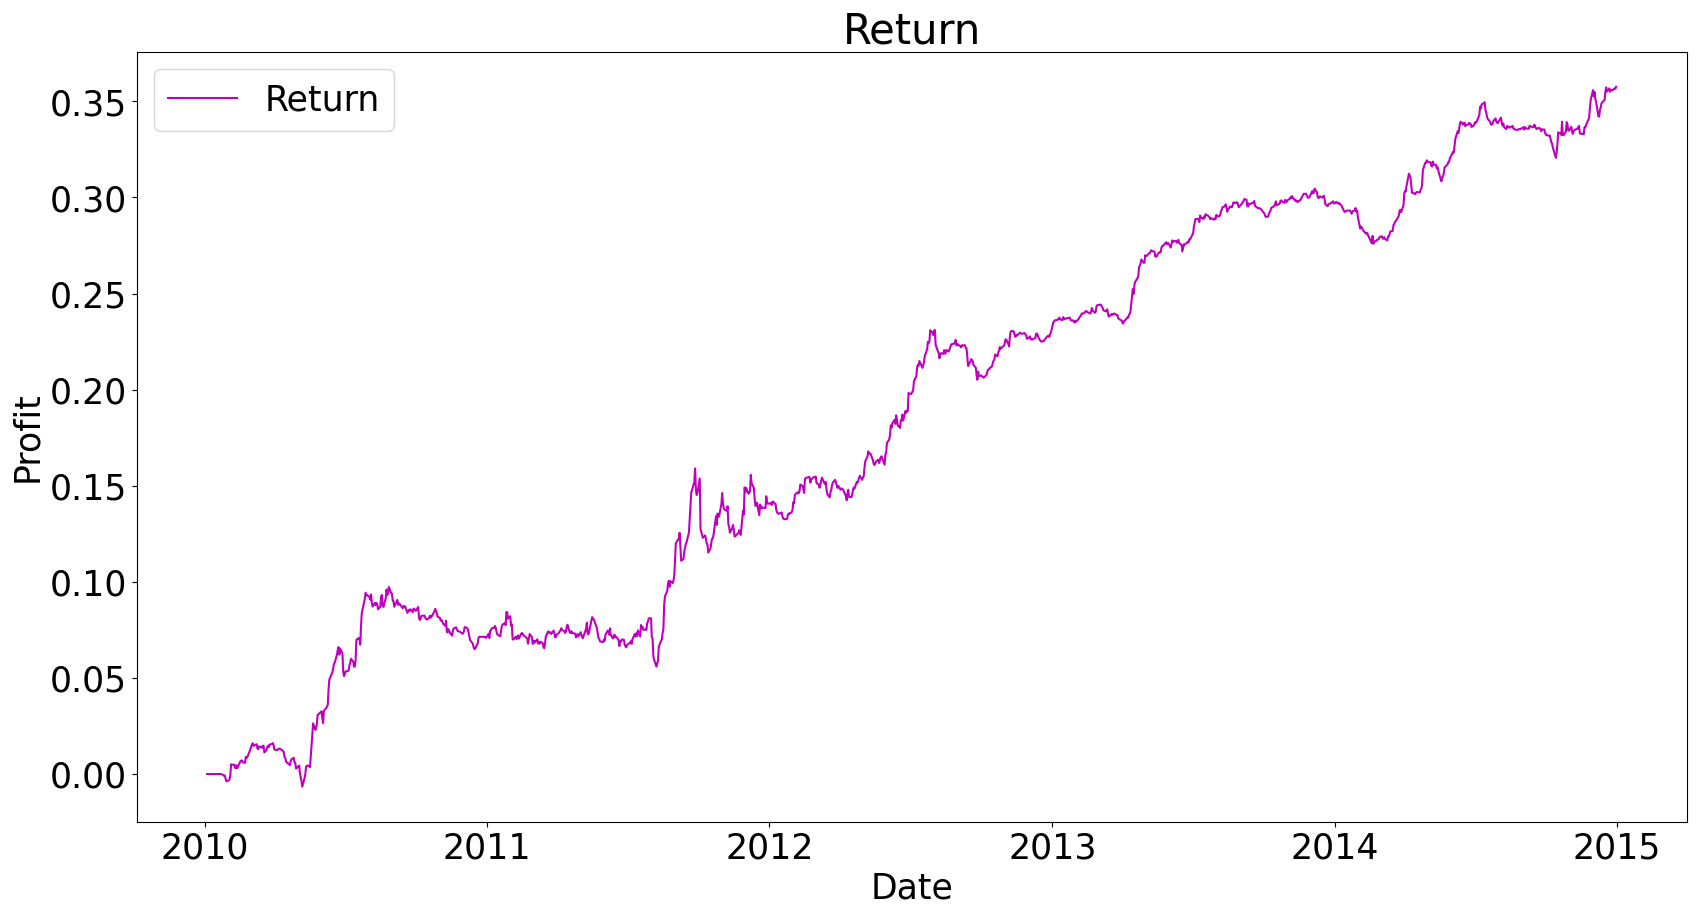

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,1.852229,0.555419,0.070950,0.357626,0.028952
1,2011,1.154838,0.580714,0.070007,0.357626,0.028952
2,2012,2.779225,0.589789,0.095124,0.357626,0.028952
3,2013,2.641318,0.585191,0.060657,0.357626,0.028952
4,2014,1.792953,0.592249,0.060888,0.357626,0.028952


In [ ]:
AlphaStats(alp1)

## Альфа 2



In [ ]:
alp2 = df_h/df
alp2 = normalization(neutralization(alp2))
alp2 = rank(alp2)
alp2 = decay(alp2, 2)

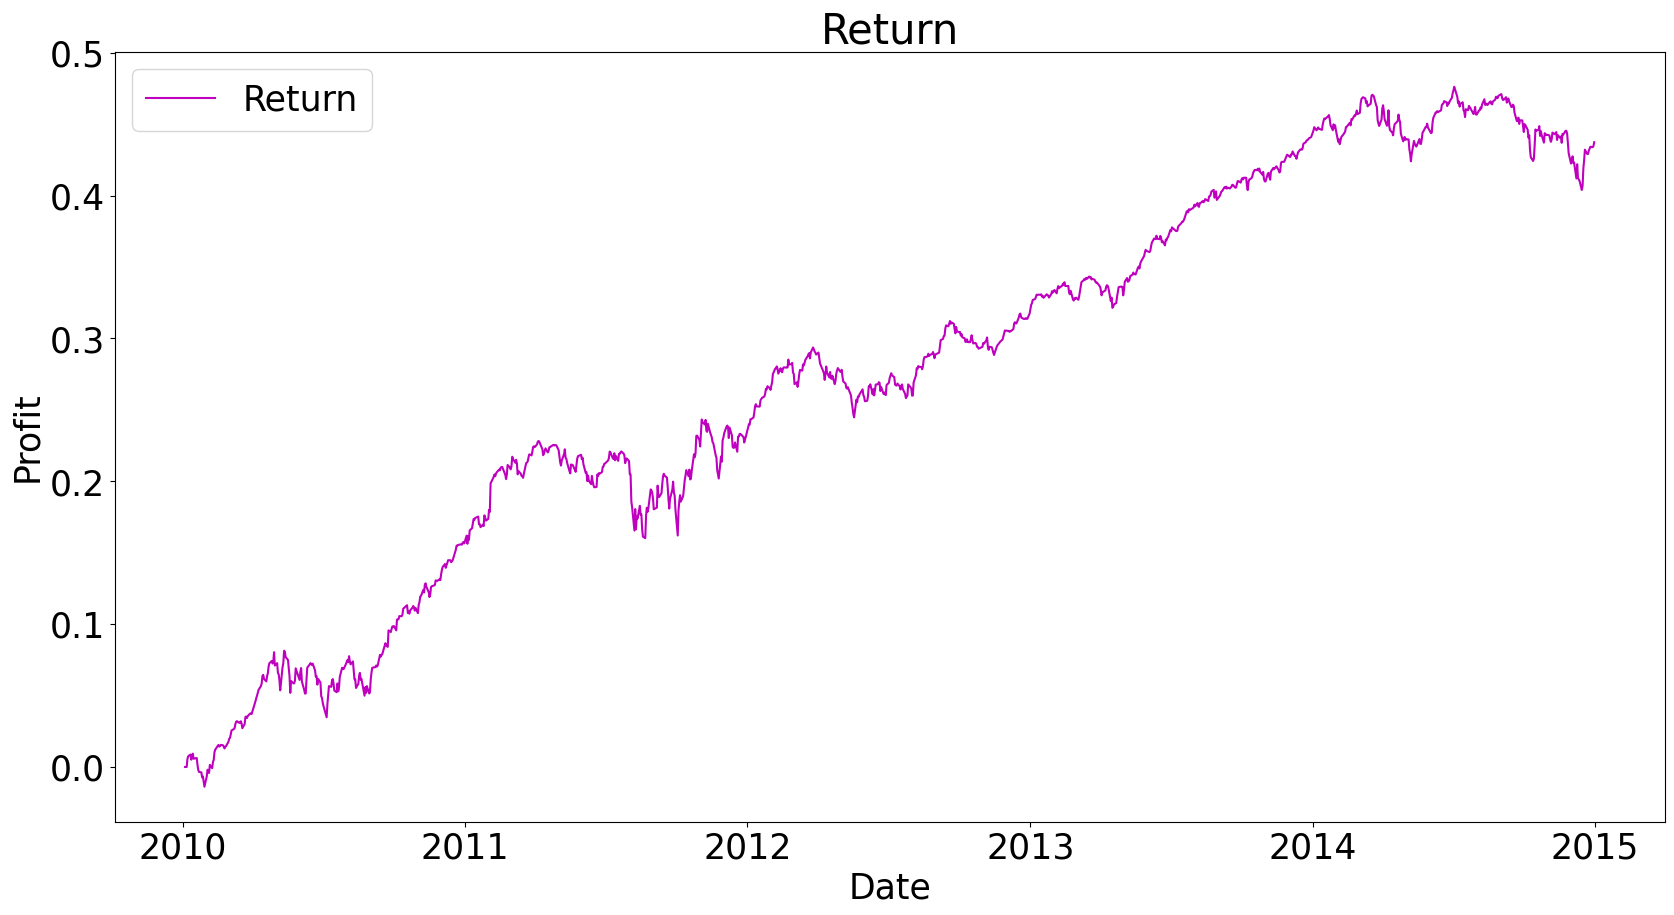

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,2.549222,0.716060,0.156538,0.437382,0.072274
1,2011,0.959619,0.693300,0.083395,0.437382,0.072274
2,2012,1.851522,0.692280,0.087012,0.437382,0.072274
3,2013,3.399508,0.709334,0.118773,0.437382,0.072274
4,2014,-0.138887,0.647939,-0.008335,0.437382,0.072274


In [ ]:
AlphaStats(alp2)

## Альфа 3

In [ ]:
alp3 = rank((-1*((1-(df_o/df**2))**5)))
alp3 = truncate(alp3, 0.002)
alp3 = decay2(alp3,3)

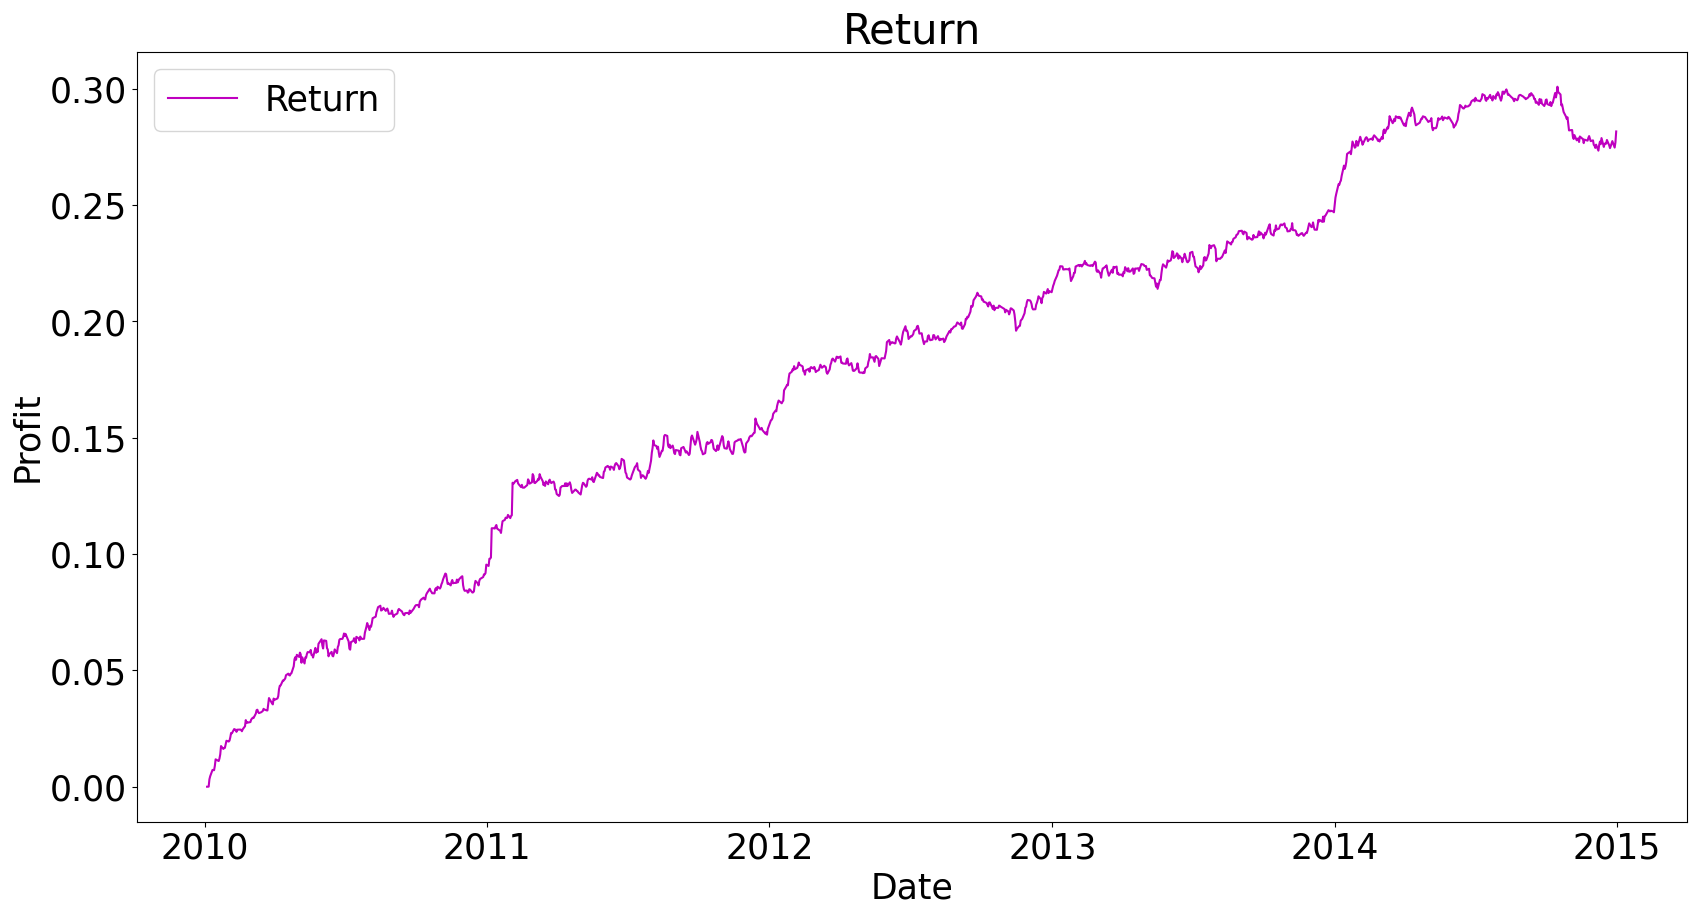

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,4.262717,0.009539,0.095434,0.281574,0.027467
1,2011,1.954821,0.009328,0.061998,0.281574,0.027467
2,2012,2.808557,0.007933,0.059931,0.281574,0.027467
3,2013,1.709069,0.007041,0.041549,0.281574,0.027467
4,2014,0.919888,0.007085,0.022663,0.281574,0.027467


In [ ]:
AlphaStats(alp3)

## Альфа 4

In [ ]:
alp4 = (df_h + df_l)/2
alp4 = alp4.mask((alp4 > df), other=1)*(-1)
alp4 = rank(alp4)
alp4 = decay2(alp4, 5)

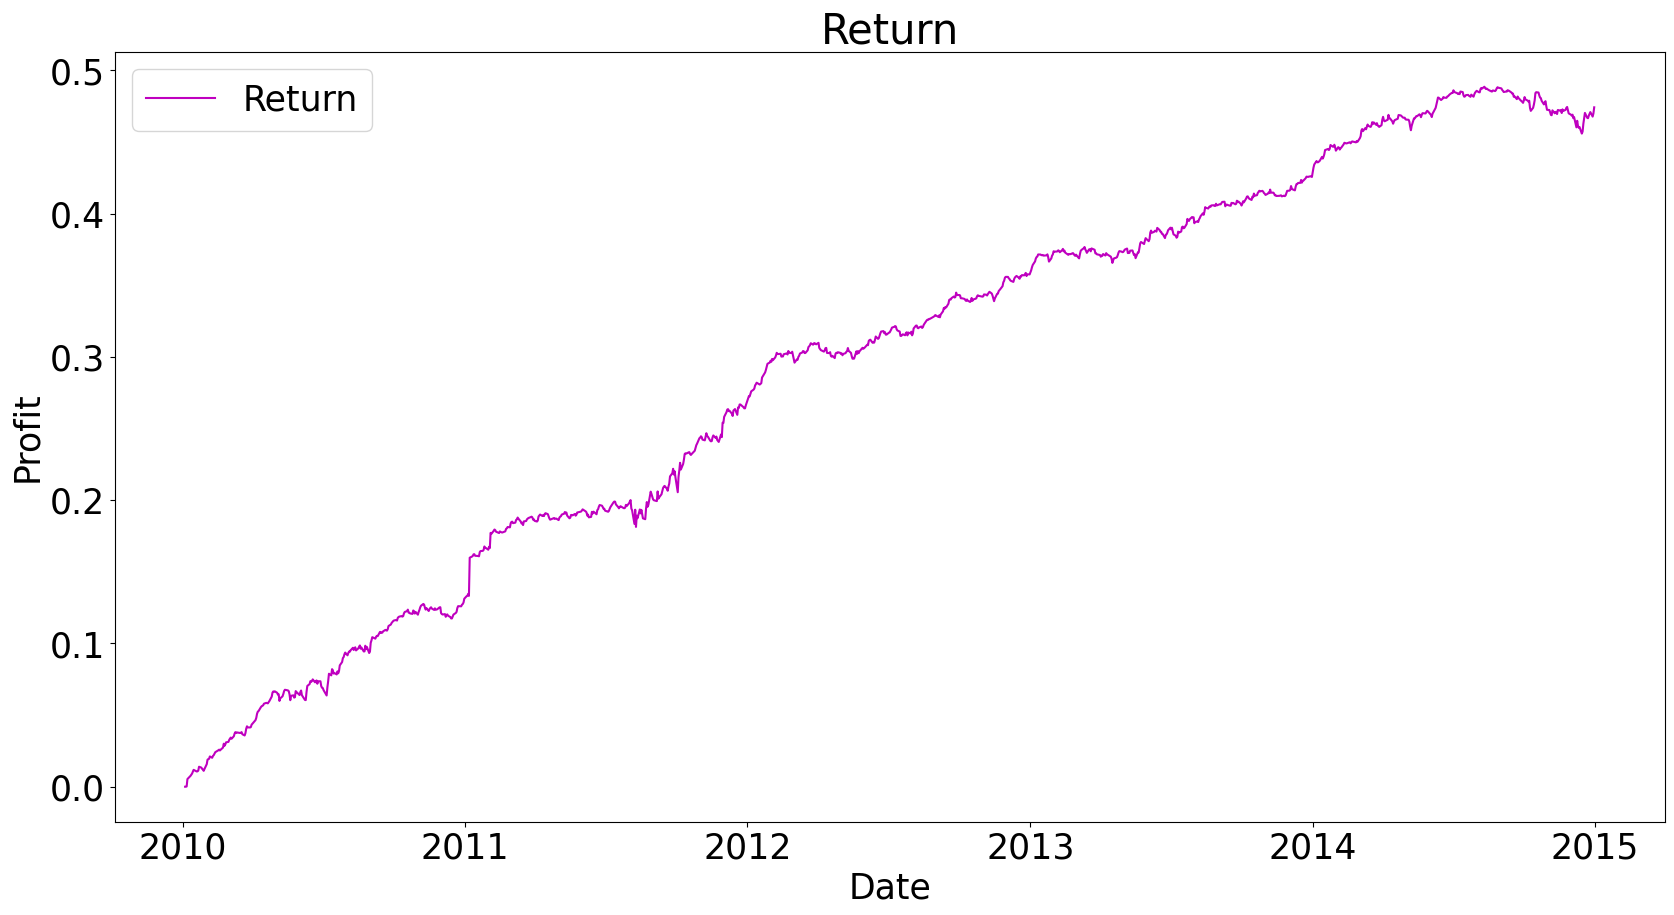

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,4.834838,0.366626,0.131219,0.474144,0.032704
1,2011,2.808774,0.378162,0.141385,0.474144,0.032704
2,2012,4.068083,0.375378,0.091500,0.474144,0.032704
3,2013,3.055839,0.374443,0.072537,0.474144,0.032704
4,2014,1.346375,0.395569,0.037502,0.474144,0.032704


In [ ]:
AlphaStats(alp4)

## Альфа 5

In [ ]:
alp5 = return_dd((df_h + df)**2)
alp5 = alp5.mask((alp5 > (df_h + df_l)), other=1)*(-1)
alp5 = decay(alp5, 7)

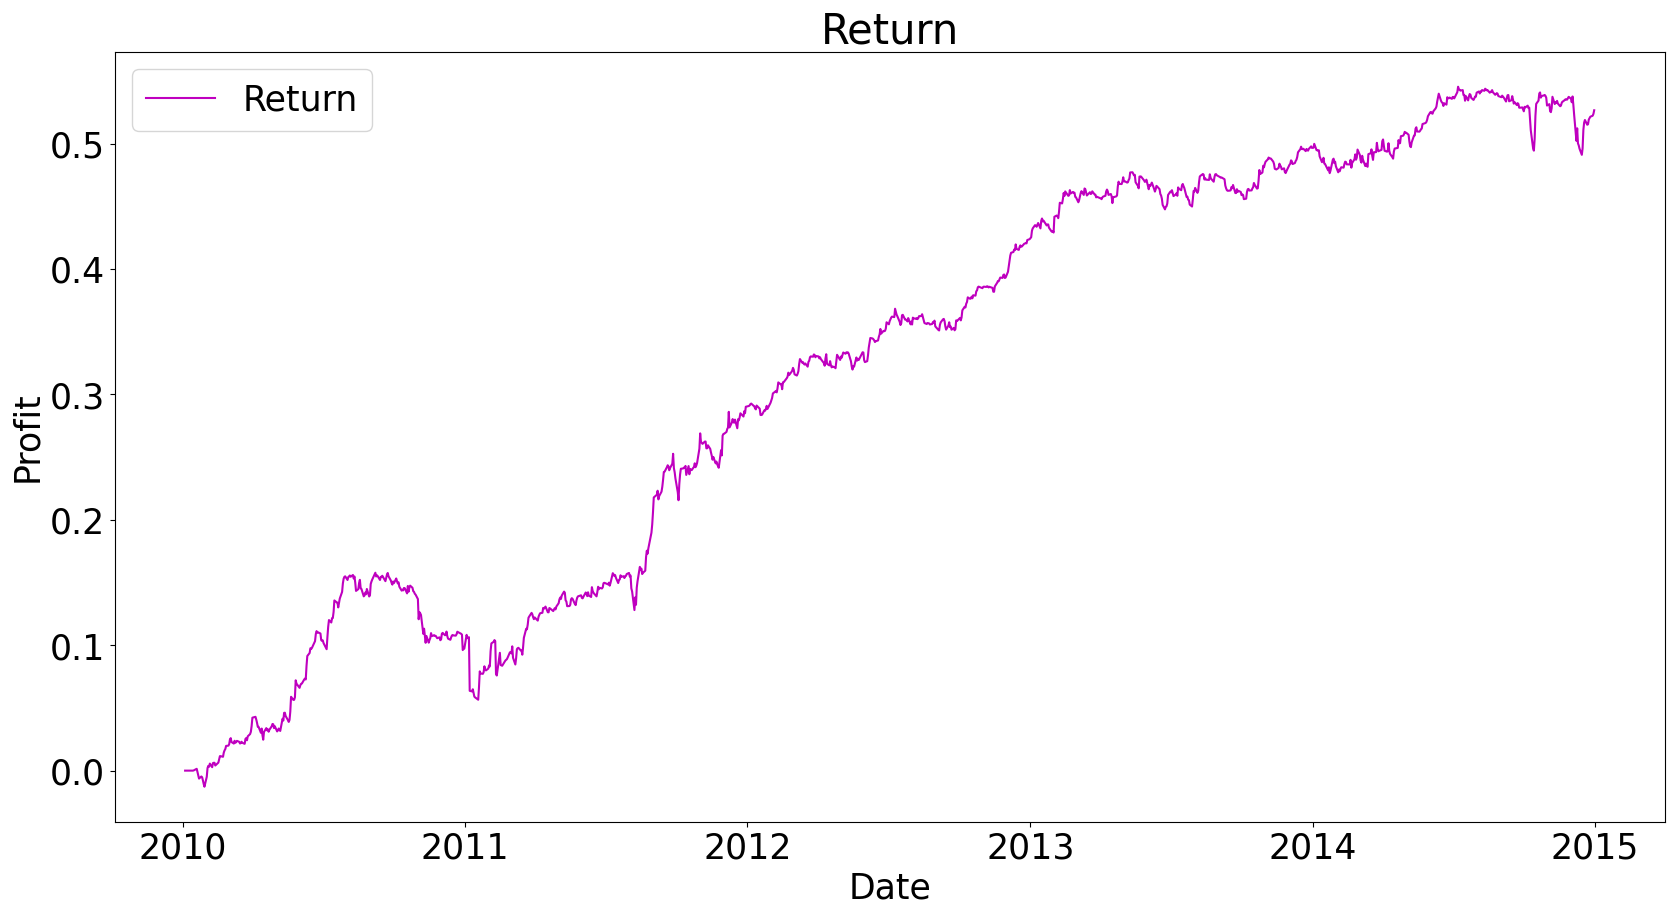

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,1.661985,0.462015,0.097286,0.526652,0.054322
1,2011,2.135858,0.485714,0.193529,0.526652,0.054322
2,2012,3.451227,0.479593,0.141648,0.526652,0.054322
3,2013,1.359425,0.468923,0.062377,0.526652,0.054322
4,2014,0.499259,0.469842,0.031811,0.526652,0.054322


In [ ]:
AlphaStats(alp5)


## Альфа 6

In [ ]:
alp6 = (df_h +df_l - 2*df)/df
alp6 = decay(alp6, 3)
alp6 = truncate(alp6, 0.003)
alp6 = rank(alp6)

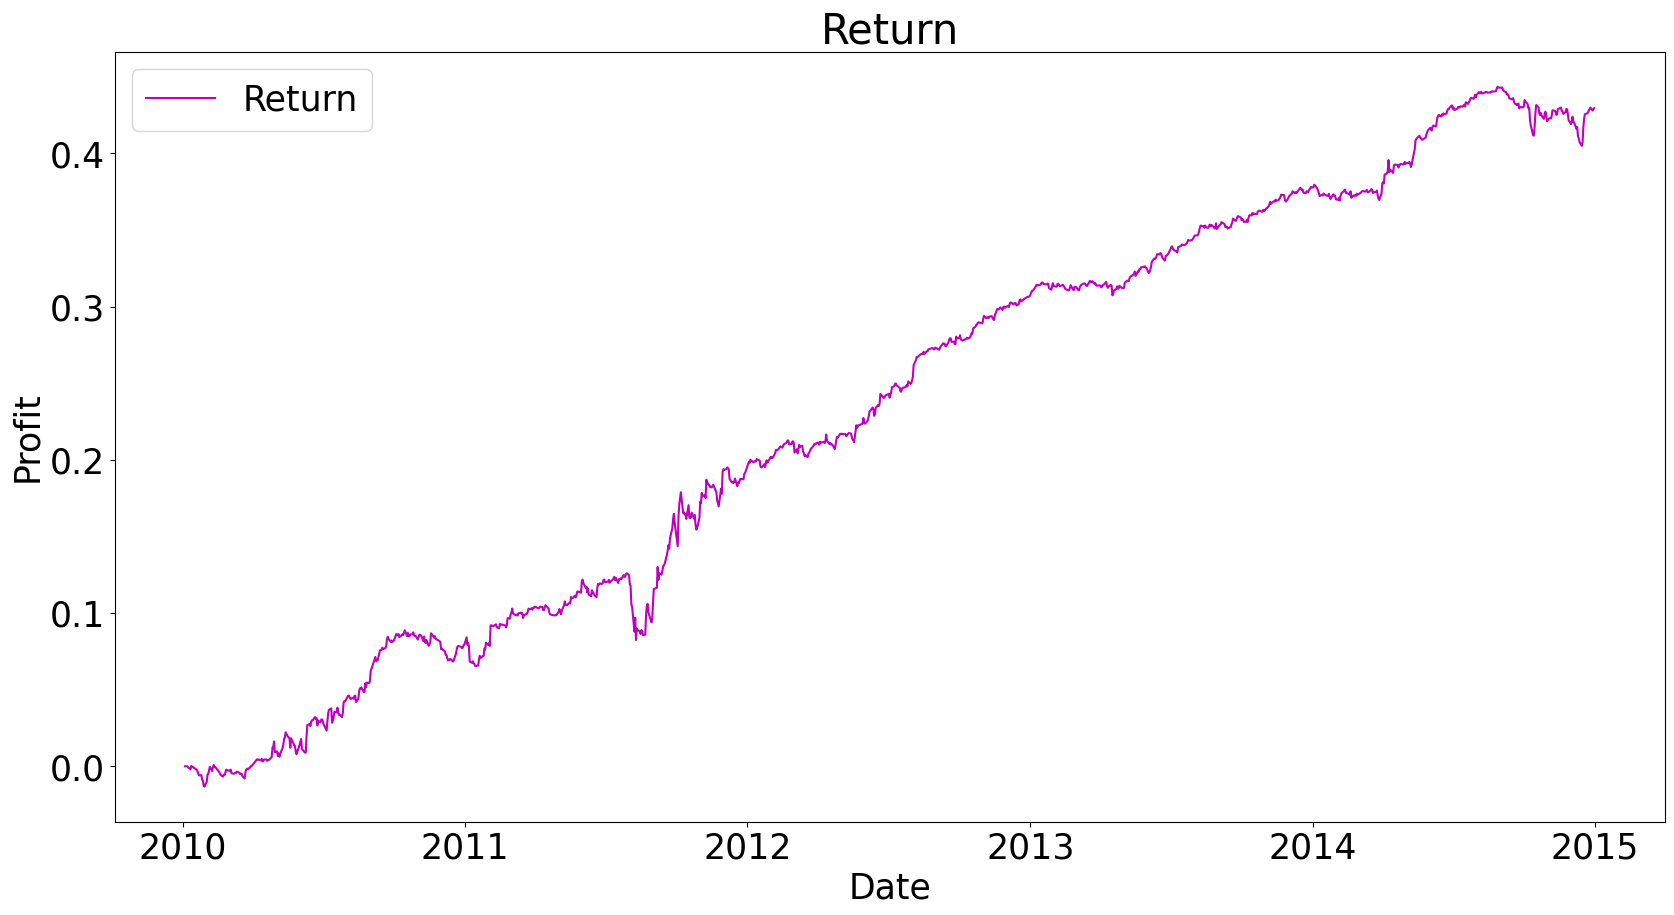

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,2.001079,0.692703,0.079276,0.429411,0.038587
1,2011,1.773854,0.701851,0.119491,0.429411,0.038587
2,2012,3.843483,0.682008,0.111476,0.429411,0.038587
3,2013,3.156031,0.683306,0.067635,0.429411,0.038587
4,2014,1.430860,0.695107,0.051533,0.429411,0.038587


In [ ]:
AlphaStats(alp6)

## Альфа 7

In [ ]:
alp7 = ts_rank((df_o+df)**2/df_v, 20)
alp7 = -decay2(alp7,2)

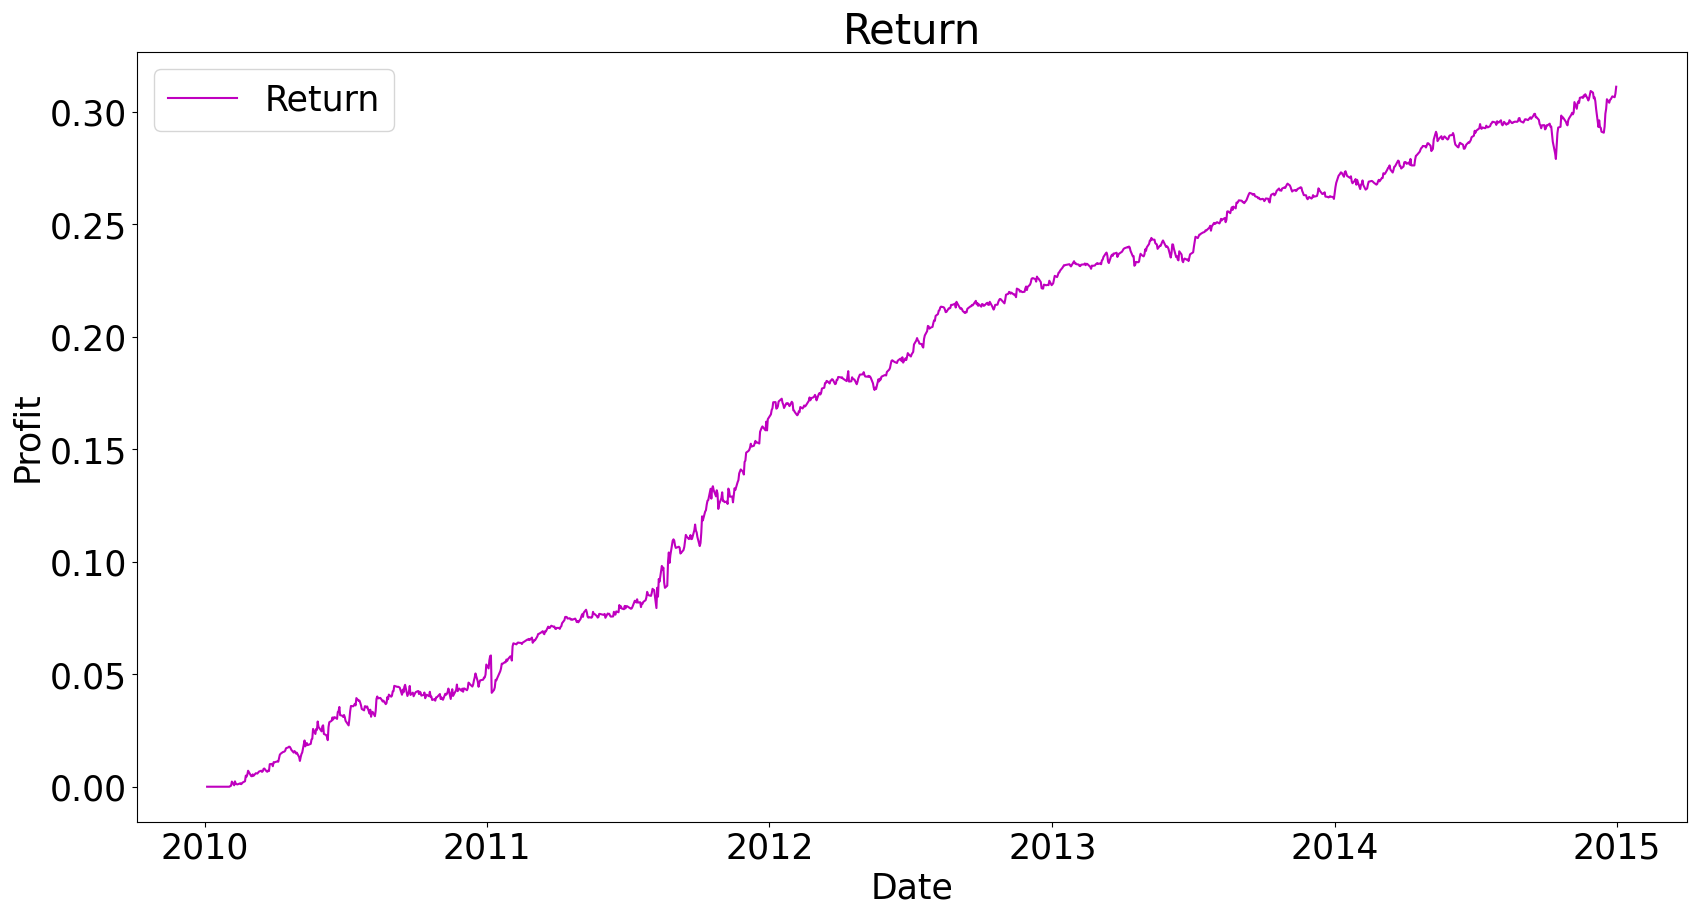

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,2.132610,0.483221,0.054311,0.311125,0.020076
1,2011,2.770467,0.527495,0.111197,0.311125,0.020076
2,2012,3.073267,0.530425,0.061565,0.311125,0.020076
3,2013,2.290174,0.521807,0.044460,0.311125,0.020076
4,2014,1.522413,0.508200,0.039593,0.311125,0.020076


In [ ]:
AlphaStats(alp7)

## Альфа 8

In [ ]:
alp8 = return_dd((df_h+df_l)**2/2)
alp8 = -ts_rank(alp8, 12)
alp8 = decay2(alp8,5)

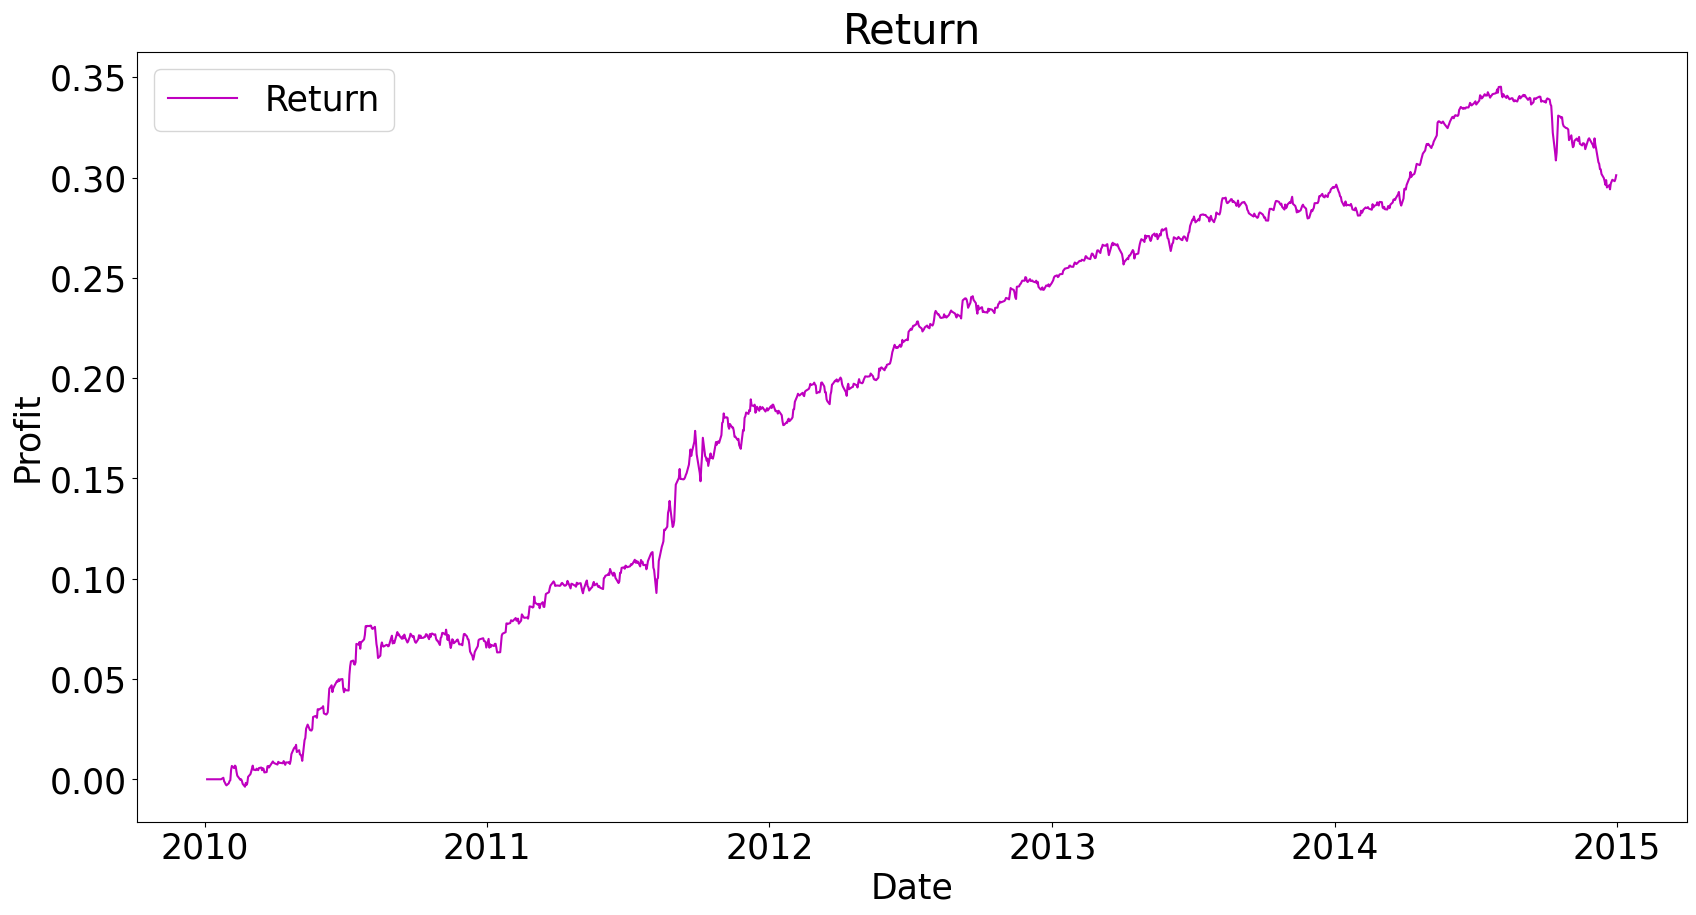

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,1.956794,0.595098,0.065667,0.30113,0.051146
1,2011,2.590947,0.621186,0.120355,0.30113,0.051146
2,2012,2.546935,0.626453,0.064737,0.30113,0.051146
3,2013,1.816290,0.627772,0.042344,0.30113,0.051146
4,2014,0.249058,0.625005,0.008026,0.30113,0.051146


In [ ]:
AlphaStats(alp8)

## Альфа 9

In [ ]:
alp9 = ((df_h + df_l+ df_v)/df**2)
alp9 = normalization(neutralization(alp9))
alp9 = truncate(alp9, 0.001)

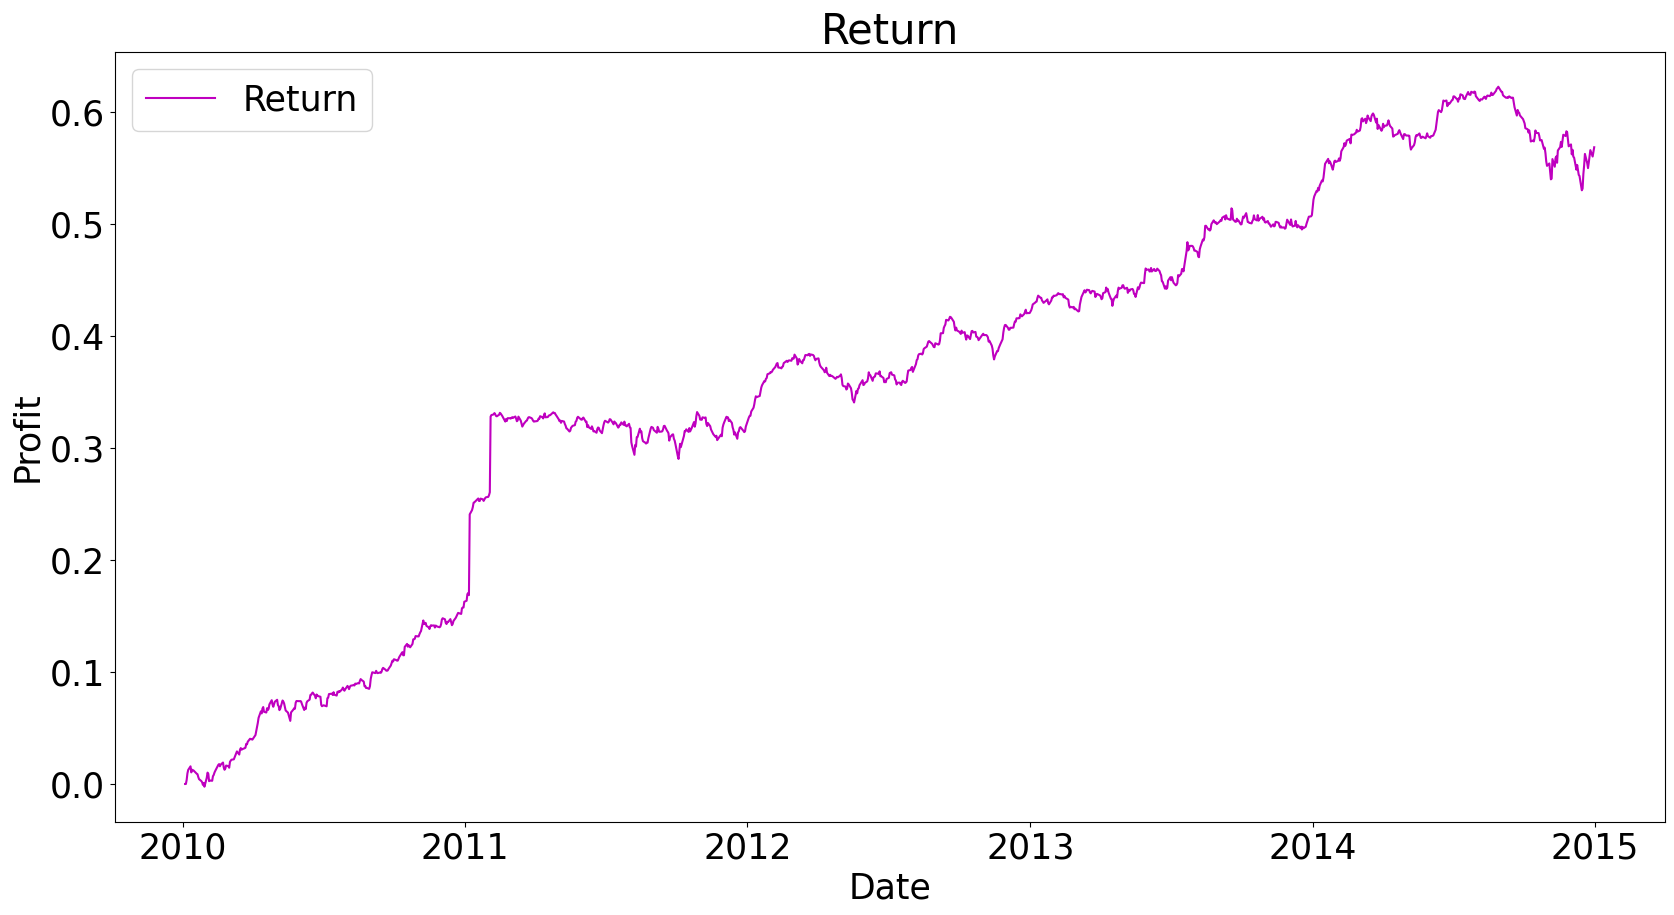

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,3.964256,0.249251,0.162720,0.568513,0.092481
1,2011,1.506296,0.213102,0.164621,0.568513,0.092481
2,2012,2.463949,0.217892,0.100829,0.568513,0.092481
3,2013,2.029520,0.205046,0.101345,0.568513,0.092481
4,2014,0.617564,0.187597,0.038998,0.568513,0.092481


In [ ]:
AlphaStats(alp9)

## Альфа 10

In [ ]:
alp10 =-df_h * df_l / df_o**2
# # alp10 = ts_rank(alp10, 25)
# alp10 = decay(alp10, 3)
alp10 = normalization(neutralization(alp10))
alp10 = decay2(alp10,2)


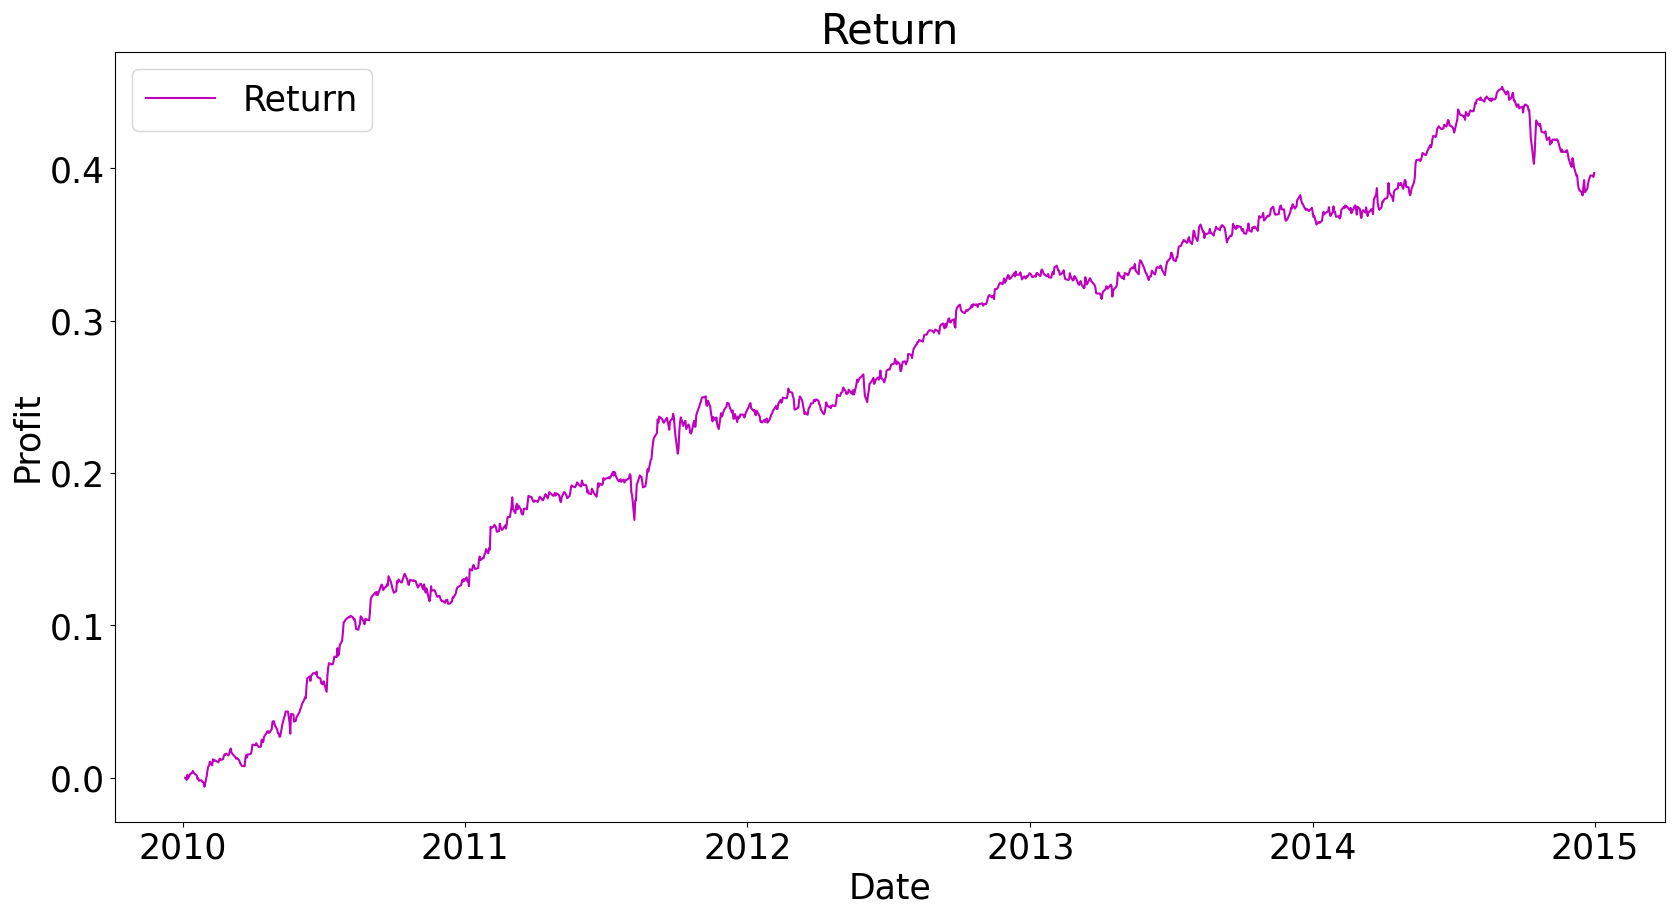

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,2.983159,0.794569,0.129220,0.396905,0.071329
1,2011,2.026463,0.798542,0.114423,0.396905,0.071329
2,2012,2.312539,0.791091,0.084908,0.396905,0.071329
3,2013,0.906315,0.787796,0.034484,0.396905,0.071329
4,2014,0.685340,0.797842,0.033869,0.396905,0.071329


In [ ]:
AlphaStats(alp10)

# Корреляция альф

<Axes: >

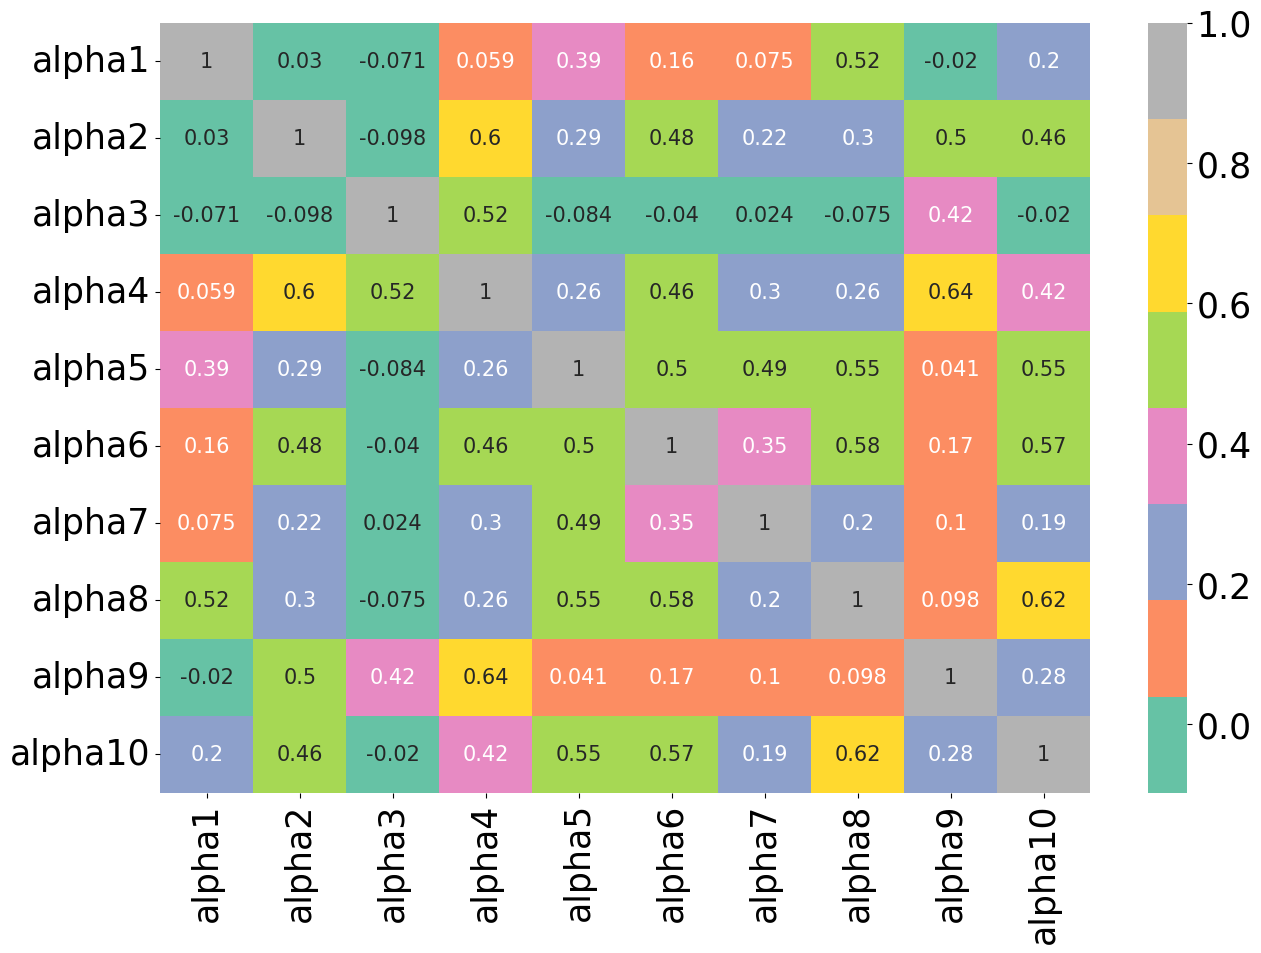

In [ ]:
correl = pd.DataFrame({
    'alpha1' : pnl(alp1),
    'alpha2' : pnl(alp2),
    'alpha3' : pnl(alp3),
    'alpha4' : pnl(alp4),
    'alpha5' : pnl(alp5),
    'alpha6' : pnl(alp6),
    'alpha7' : pnl(alp7),
    'alpha8' : pnl(alp8),
    'alpha9' : pnl(alp9),
    'alpha10' : pnl(alp10)
})
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(correl.corr(), annot=True, cmap="Set2", annot_kws={"fontsize":15}, )

# Построение портфелей


Text(0, 0.5, 'pnl')

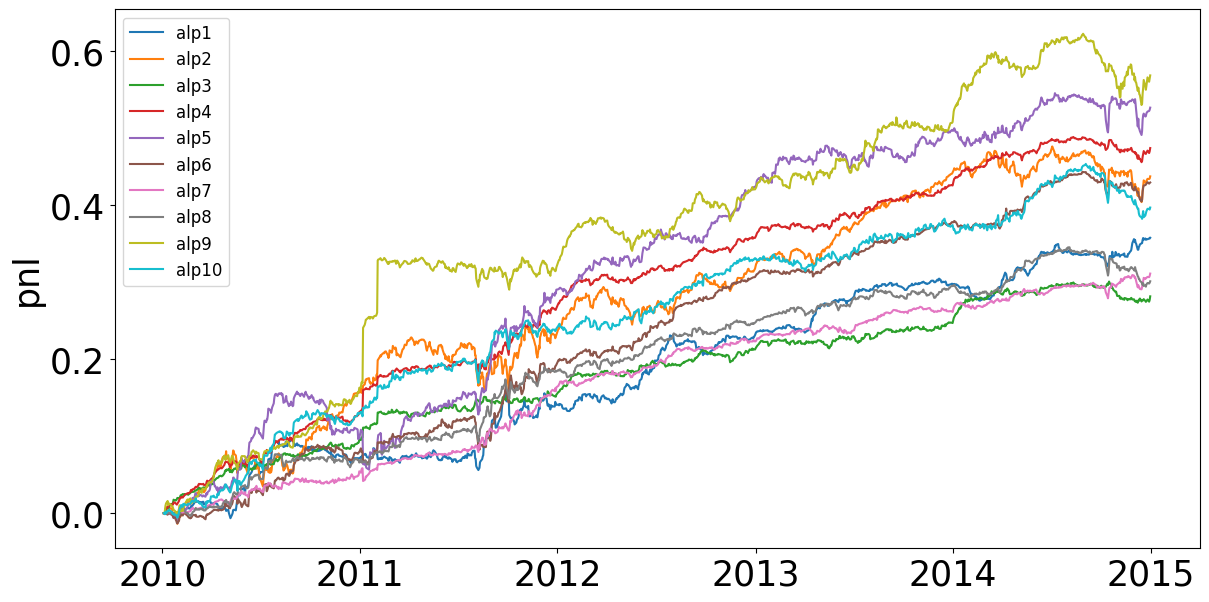

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(cumpnl(alp1),label="alp1")
plt.plot(cumpnl(alp2),label="alp2")
plt.plot(cumpnl(alp3),label="alp3")
plt.plot(cumpnl(alp4),label="alp4")
plt.plot(cumpnl(alp5),label="alp5")
plt.plot(cumpnl(alp6),label="alp6")
plt.plot(cumpnl(alp7),label="alp7")
plt.plot(cumpnl(alp8),label="alp8")
plt.plot(cumpnl(alp9),label="alp9")
plt.plot(cumpnl(alp10),label="alp10")
plt.legend(fontsize=12)
plt.ylabel('pnl')

## Портфель 1 (веса равны)

In [ ]:
ii = ['alpha1','alpha2','alpha3','alpha4','alpha5','alpha6','alpha7','alpha8','alpha9','alpha10']
n = len(ii)
# df0 = pd.DataFrame(columns=df.columns, index=df.index).fillna(0)

In [ ]:
alphas = {
    'alpha1' : alp1, # pd.DataFrame
    'alpha2' : alp2,
    'alpha3' : alp3,
    'alpha4' : alp4,
    'alpha5' : alp5,
    'alpha6' : alp6,
    'alpha7' : alp7,
    'alpha8' : alp8,
    'alpha9' : alp9,
    'alpha10' : alp10
}
#alphas['alpha1']

In [ ]:
alphas0 = {
    'alpha1' : alp1[0:252], # pd.DataFrame
    'alpha2' : alp2[0:252],
    'alpha3' : alp3[0:252],
    'alpha4' : alp4[0:252],
    'alpha5' : alp5[0:252],
    'alpha6' : alp6[0:252],
    'alpha7' : alp7[0:252],
    'alpha8' : alp8[0:252],
    'alpha9' : alp9[0:252],
    'alpha10' : alp10[0:252]
}
#alphas['alpha1']

In [ ]:
portfel_0 = (alphas0[ii[0]] + alphas0[ii[1]] + alphas0[ii[2]] +  alphas0[ii[3]] + alphas0[ii[4]] + alphas0[ii[5]] +  alphas0[ii[6]] + alphas0[ii[7]] + alphas0[ii[8]] +  alphas0[ii[9]])/n

In [ ]:
portfel_1 = (alphas[ii[0]] + alphas[ii[1]] + alphas[ii[2]] +  alphas[ii[3]] + alphas[ii[4]] + alphas[ii[5]] +  alphas[ii[6]] + alphas[ii[7]] + alphas[ii[8]] +  alphas[ii[9]])/n

In [ ]:
portfel_0 = normalization(neutralization(portfel_0))

In [ ]:
portfel_1 = normalization(neutralization(portfel_1))

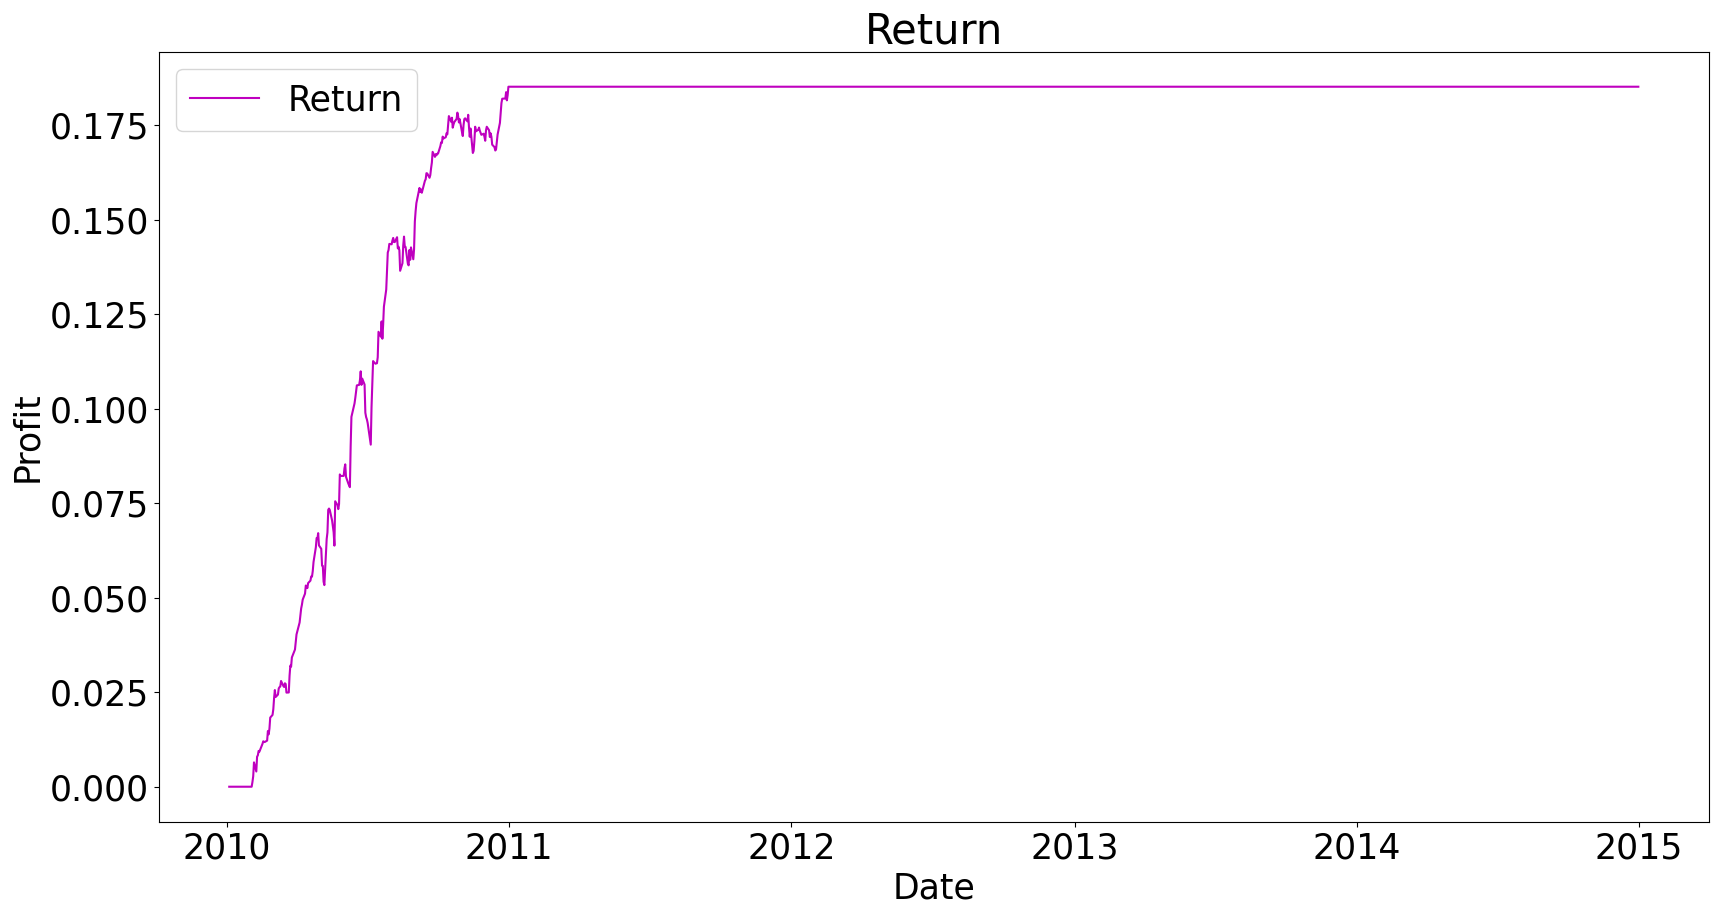

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,4.459638,0.479041,0.18514,0.18514,0
1,2011,NaN,NaN,0.00000,0.18514,0
2,2012,NaN,NaN,0.00000,0.18514,0
3,2013,NaN,NaN,0.00000,0.18514,0
4,2014,NaN,NaN,0.00000,0.18514,0


In [ ]:
AlphaStats(portfel_0)

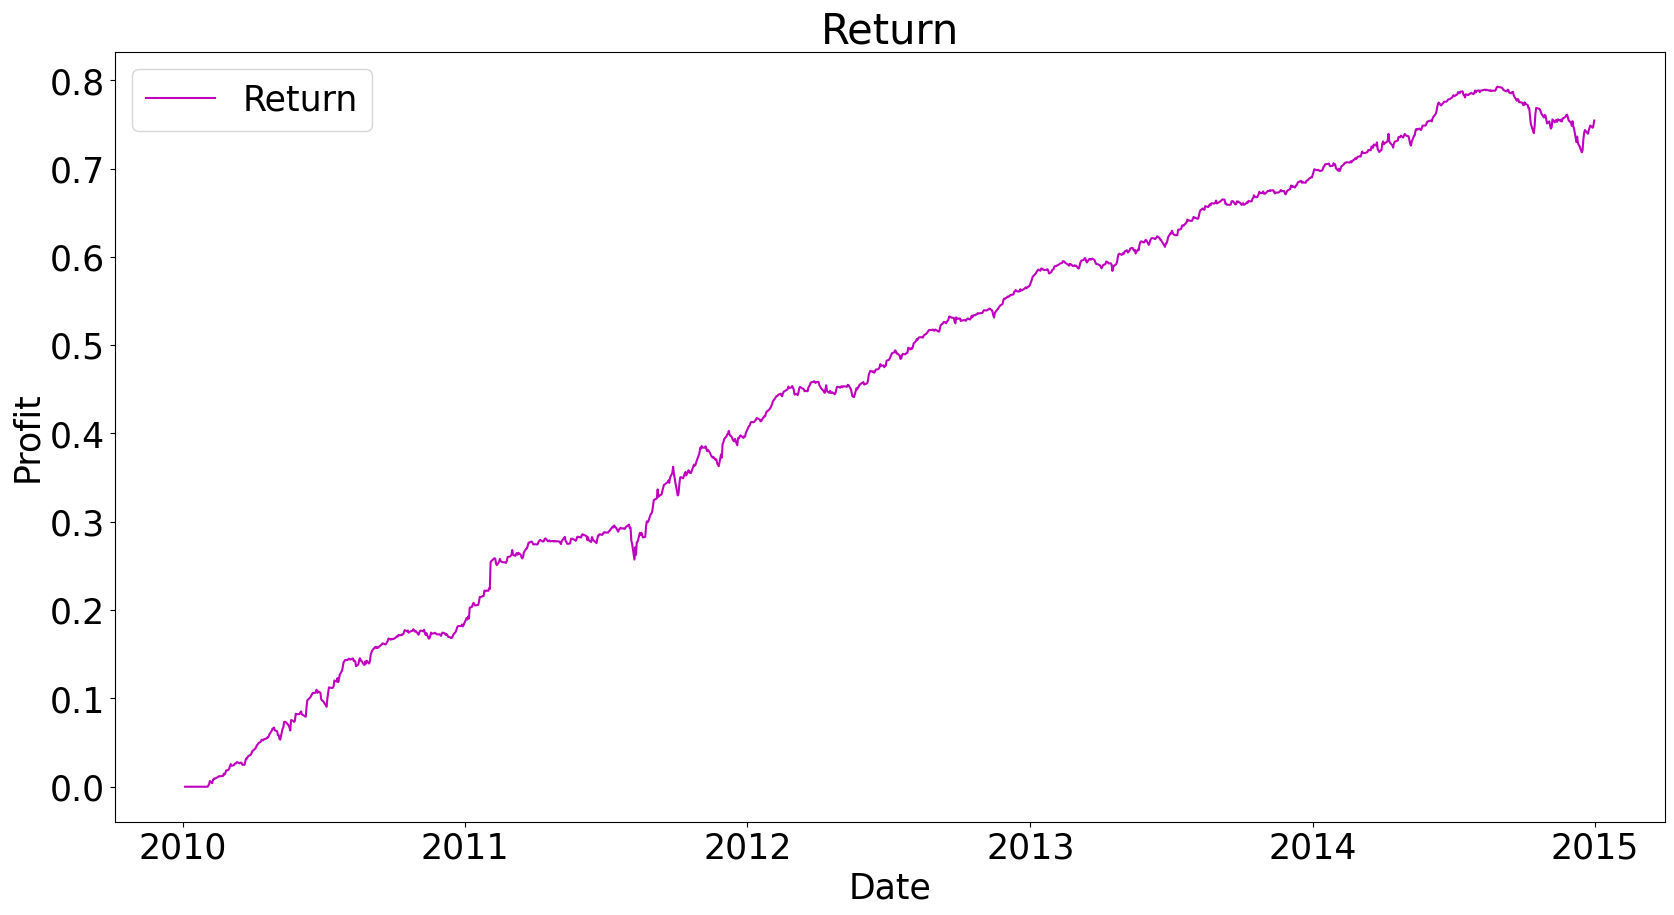

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,4.459638,0.479041,0.185140,0.754362,0.07429
1,2011,3.138537,0.512302,0.223228,0.754362,0.07429
2,2012,4.909866,0.511732,0.169287,0.754362,0.07429
3,2013,3.783101,0.509611,0.120673,0.754362,0.07429
4,2014,1.108495,0.504609,0.056034,0.754362,0.07429


In [ ]:
AlphaStats(portfel_1)

### Портфель 2 (веса пропорциональны sharp за 1 год)

In [ ]:
def sharpe5(alp, i):
  return pnl(alp)[252*i:252*(i+1)].mean() / pnl(alp)[252*i:252*(i+1)].std() * 252**0.5

In [ ]:
portfel_2 =[]
for k in range(5):

  ii = ['alpha1','alpha2','alpha3','alpha4','alpha5','alpha6','alpha7','alpha8','alpha9','alpha10']

  alphas00 = {
    'alpha1' : alp1[252*k:252*(k+1)], # pd.DataFrame
    'alpha2' : alp2[252*k:252*(k+1)],
    'alpha3' : alp3[252*k:252*(k+1)],
    'alpha4' : alp4[252*k:252*(k+1)],
    'alpha5' : alp5[252*k:252*(k+1)],
    'alpha6' : alp6[252*k:252*(k+1)],
    'alpha7' : alp7[252*k:252*(k+1)],
    'alpha8' : alp8[252*k:252*(k+1)],
    'alpha9' : alp9[252*k:252*(k+1)],
    'alpha10' : alp10[252*k:252*(k+1)]}

  alphas_sh =  {
    'alpha1' : sharpe5(alp1,(k)), # sharp за предыдуший год
    'alpha2' : sharpe5(alp2,(k)),
    'alpha3' : sharpe5(alp3,(k)),
    'alpha4' : sharpe5(alp4,(k)),
    'alpha5' : sharpe5(alp5,(k)),
    'alpha6' : sharpe5(alp6,(k)),
    'alpha7' : sharpe5(alp7,(k)),
    'alpha8' : sharpe5(alp8,(k)),
    'alpha9' : sharpe5(alp9,(k)),
    'alpha10' : sharpe5(alp10,(k))}


  sum_sh = sum(alphas_sh.values()) #сумма sharp за  год всех альф
  alphas_mas2 = [value / sum_sh for value in alphas_sh.values()] # веса всех альф ??????????
  port2 = {
      'alpha1' : [],
      'alpha2' : [],
      'alpha3' : [],
      'alpha4' : [],
      'alpha5' : [],
      'alpha6' : [],
      'alpha7' : [],
      'alpha8' : [],
      'alpha9' : [],
      'alpha10' : []
  }

  for m in range(len(ii)):
    port2[ii[m]] = (alphas00[ii[m]] * alphas_mas2[m])  # альфа умноженная на вес

  # Портфель за 1 год
  portfel_2_i = port2[ii[0]] + port2[ii[1]] + port2[ii[2]] +  port2[ii[3]] + port2[ii[4]] + port2[ii[5]] +  port2[ii[6]] + port2[ii[7]] + port2[ii[8]] +  port2[ii[9]]
  portfel_2.append(portfel_2_i)
  # portfel_3 += portfel_3_i

In [ ]:
portfel_22 = portfel_1.append(portfel_2[1])
portfel_22 = portfel_22.append(portfel_2[2])
portfel_22 = portfel_22.append(portfel_2[3])
portfel_22 = portfel_22.append(portfel_2[4])
# portfel_22 = portfel_22.append(portfel_2[4])

In [ ]:
portfel_22 = normalization(neutralization(portfel_22))

In [ ]:
portfel_22.sum(axis=1) #проверка нейтрализации

2010-01-04    0.000000e+00
2010-01-05    0.000000e+00
2010-01-06    0.000000e+00
2010-01-07    0.000000e+00
2010-01-08    0.000000e+00
                  ...     
2014-12-24   -3.469447e-18
2014-12-26   -3.122502e-17
2014-12-29    2.081668e-17
2014-12-30   -1.387779e-17
2014-12-31   -1.734723e-17
Length: 2262, dtype: float64

In [ ]:
portfel_22.abs().sum(axis=1) # нормализация проверка

2010-01-04    0.0
2010-01-05    0.0
2010-01-06    0.0
2010-01-07    0.0
2010-01-08    0.0
             ... 
2014-12-24    1.0
2014-12-26    1.0
2014-12-29    1.0
2014-12-30    1.0
2014-12-31    1.0
Length: 2262, dtype: float64

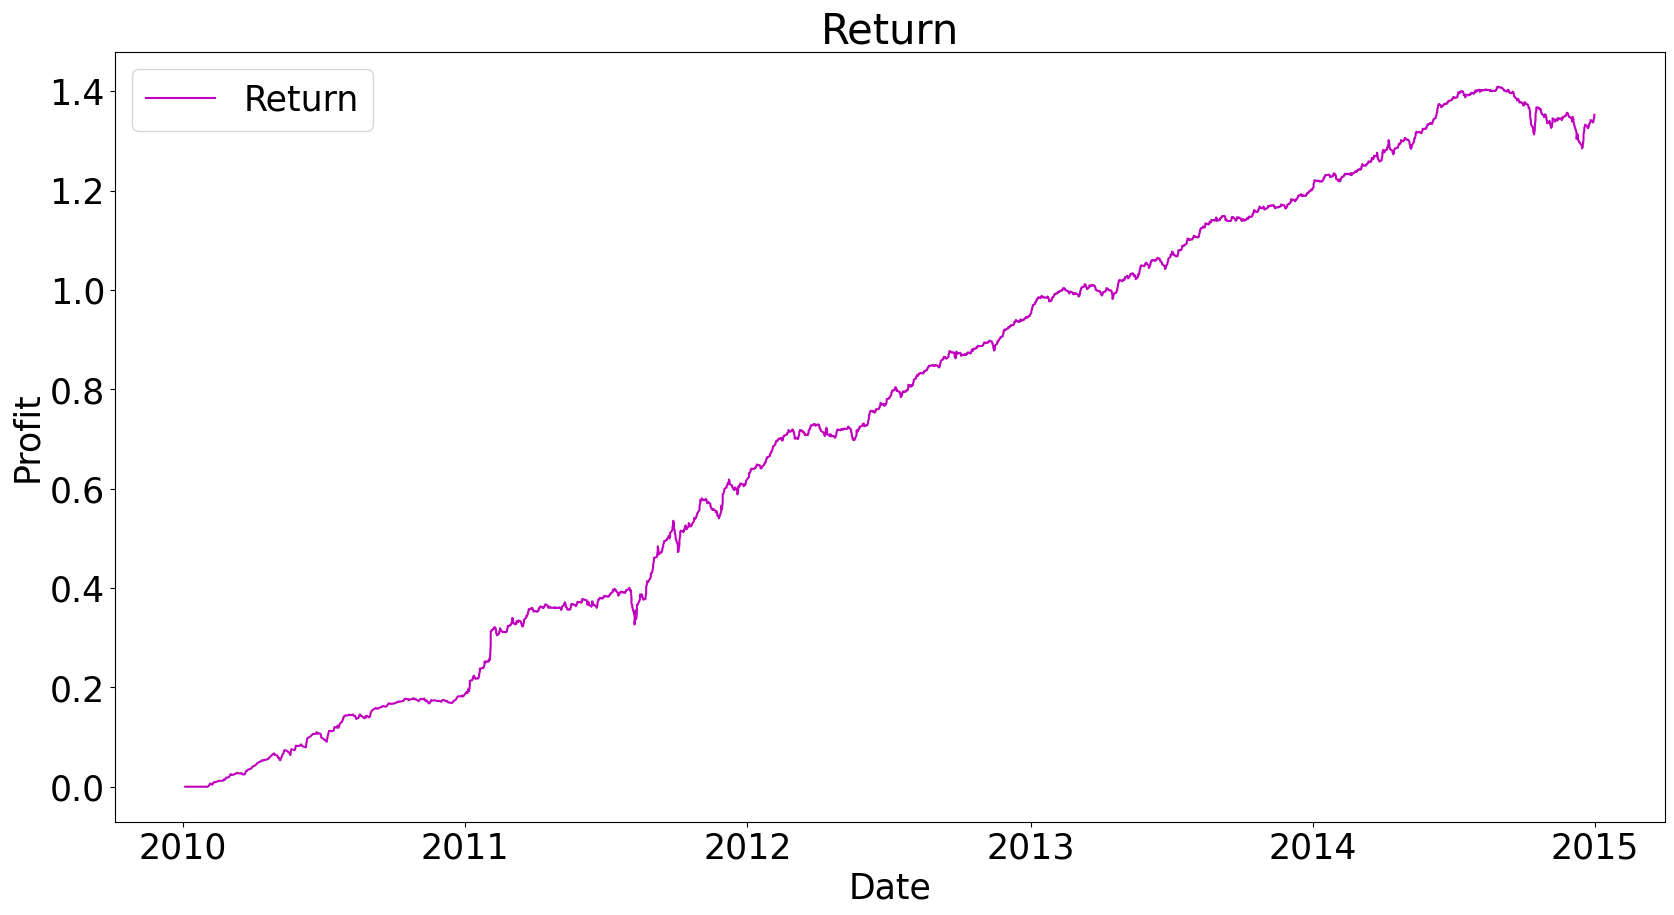

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,4.459638,0.479041,0.185140,1.352644,0.07429
1,2011,3.608385,0.512302,0.197468,1.352644,0.07429
2,2012,3.096652,0.511732,0.248300,1.352644,0.07429
3,2013,4.131180,0.509611,0.153890,1.352644,0.07429
4,2014,6.108532,0.508384,0.184756,1.352644,0.07429


In [ ]:
AlphaStats(portfel_22)

### Портфель 3 (веса пропорциональны pnl за 1 год)

In [ ]:
def cumpnl5(alp, i):
    return (pnl(alp)[252*i:252*(i+1)].sum())

  # суммарная доходность за 5 год

In [ ]:
portfel_3 =[]
for k in range(5):

  ii = ['alpha1','alpha2','alpha3','alpha4','alpha5','alpha6','alpha7','alpha8','alpha9','alpha10']

  alphas00 = {
    'alpha1' : alp1[252*k:252*(k+1)], # pd.DataFrame
    'alpha2' : alp2[252*k:252*(k+1)],
    'alpha3' : alp3[252*k:252*(k+1)],
    'alpha4' : alp4[252*k:252*(k+1)],
    'alpha5' : alp5[252*k:252*(k+1)],
    'alpha6' : alp6[252*k:252*(k+1)],
    'alpha7' : alp7[252*k:252*(k+1)],
    'alpha8' : alp8[252*k:252*(k+1)],
    'alpha9' : alp9[252*k:252*(k+1)],
    'alpha10' : alp10[252*k:252*(k+1)]}

  alphas_pnl = {
    'alpha1' : cumpnl5(alp1,k-1), # pnl за год
    'alpha2' : cumpnl5(alp2,k-1),
    'alpha3' : cumpnl5(alp3,k-1),
    'alpha4' : cumpnl5(alp4,k-1),
    'alpha5' : cumpnl5(alp5,k-1),
    'alpha6' : cumpnl5(alp6,k-1),
    'alpha7' : cumpnl5(alp7,k-1),
    'alpha8' : cumpnl5(alp8,k-1),
    'alpha9' : cumpnl5(alp9,k-1),
    'alpha10' : cumpnl5(alp10,k-1)
}


  sum_pnl = sum(alphas_pnl.values()) #сумма pnl за 5 год всех альф
  alphas_mas3 = [value / sum_pnl for value in alphas_pnl.values()] # веса всех альф

  port3 = {
      'alpha1' : [],
      'alpha2' : [],
      'alpha3' : [],
      'alpha4' : [],
      'alpha5' : [],
      'alpha6' : [],
      'alpha7' : [],
      'alpha8' : [],
      'alpha9' : [],
      'alpha10' : []
  }

  for m in range(len(ii)):
    port3[ii[m]] = (alphas00[ii[m]] * alphas_mas3[m])  # альфа умноженная на вес

  # Портфель за 1 год
  portfel_3_i = port3[ii[0]] + port3[ii[1]] + port3[ii[2]] +  port3[ii[3]] + port3[ii[4]] + port3[ii[5]] +  port3[ii[6]] + port3[ii[7]] + port3[ii[8]] +  port3[ii[9]]
  portfel_3.append(portfel_3_i)
  # portfel_3 += portfel_3_i

In [ ]:
portfel_33 = portfel_1.append(portfel_3[1])
# portfel_33 = portfel_33.append(portfel_3[1])
portfel_33 = portfel_33.append(portfel_3[2])
portfel_33 = portfel_33.append(portfel_3[3])
portfel_33 = portfel_33.append(portfel_3[4])

In [ ]:
portfel_33 = normalization(neutralization(portfel_33))

In [ ]:
portfel_22.sum(axis=1) #проверка нейтрализации

2010-01-04    0.000000e+00
2010-01-05    0.000000e+00
2010-01-06    0.000000e+00
2010-01-07    0.000000e+00
2010-01-08    0.000000e+00
                  ...     
2014-12-24   -3.469447e-18
2014-12-26   -3.122502e-17
2014-12-29    2.081668e-17
2014-12-30   -1.387779e-17
2014-12-31   -1.734723e-17
Length: 2262, dtype: float64

In [ ]:
portfel_22.abs().sum(axis=1) # нормализация проверка

2010-01-04    0.0
2010-01-05    0.0
2010-01-06    0.0
2010-01-07    0.0
2010-01-08    0.0
             ... 
2014-12-24    1.0
2014-12-26    1.0
2014-12-29    1.0
2014-12-30    1.0
2014-12-31    1.0
Length: 2262, dtype: float64

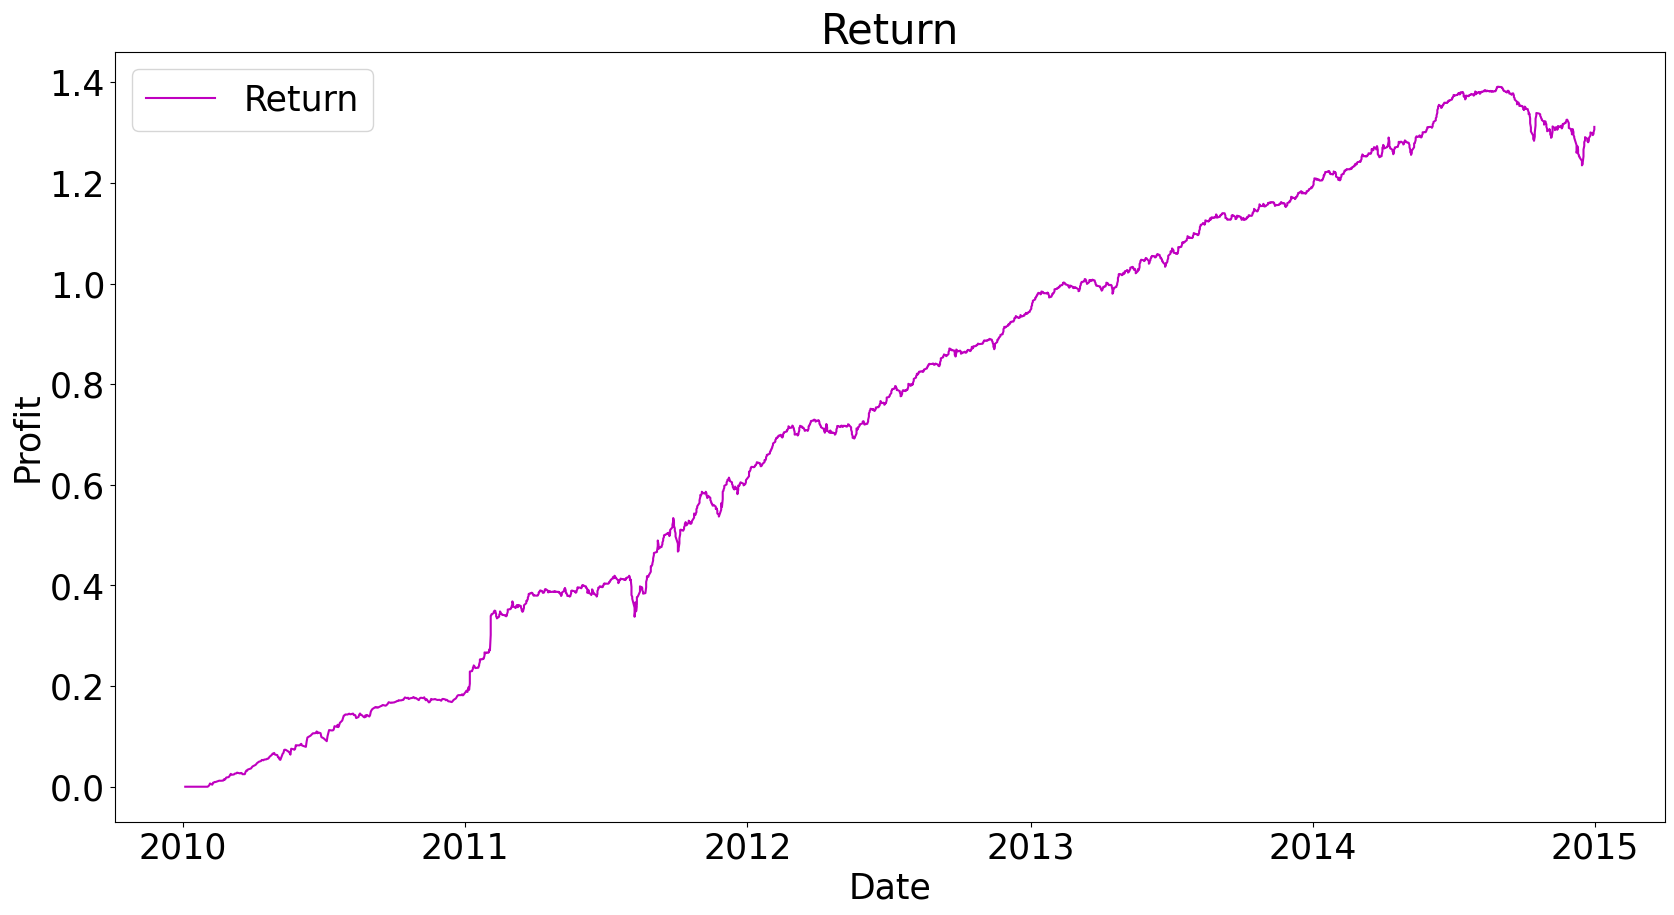

,years,sharpes,turnovers,cumpnls,pnl_sum,drawdownss
0,2010,4.459638,0.479041,0.185140,1.311244,0.07429
1,2011,3.319052,0.512302,0.218268,1.311244,0.07429
2,2012,2.663045,0.511732,0.222595,1.311244,0.07429
3,2013,3.968481,0.509611,0.152458,1.311244,0.07429
4,2014,6.023997,0.508340,0.187329,1.311244,0.07429


In [ ]:
AlphaStats(portfel_33)